Churn Project


# <font color='orangered'>Stage 1</font>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


**Churn Prediction**<br>
* Memprediksi apakah suatu customer akan churn atau tidak<br>


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import under_sampling, over_sampling
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.20.1
pandas version :  1.2.4
seaborn version :  0.11.1


In [3]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

#### <font color='yellow'>Load Data</font>

In [4]:
# Import Excel
df = pd.ExcelFile('E Commerce Dataset.xlsx')
df.sheet_names

['Data Dict', 'E Comm']

In [5]:
# Extract 'E Comm' sheet
df = df.parse('E Comm')
df.head()

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

#### <font color='yellow'>Feature Engineering</font>

In [6]:
# Replace 0 and 1 to 'No' and 'Yes'
df['Complain_encoded'] = np.where(df['Complain'] == 1, 'Yes', 'No')

In [7]:
df.duplicated().sum()

0

In [8]:
# Drop unused columns
df = df.drop(columns=['CustomerID', 'Complain'])

In [9]:
# Add new column 'AverageCashback'
df['AverageCashback'] = df['CashbackAmount'] / df['OrderCount']

In [10]:
# 
df['PreferredLoginDevice'] = np.where(df['PreferredLoginDevice'] == 'Phone', 'Mobile Phone', df['PreferredLoginDevice'])
df['PreferredLoginDevice'].value_counts()

Mobile Phone    3996
Computer        1634
Name: PreferredLoginDevice, dtype: int64

In [11]:
#
df['PreferredPaymentMode'] = np.where(df['PreferredPaymentMode'] == 'CC', 'Credit Card',
                                      np.where(df['PreferredPaymentMode'] == 'COD', 'Cash on Delivery', df['PreferredPaymentMode'] ))
df['PreferredPaymentMode'].value_counts()

Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: PreferredPaymentMode, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  OrderAmountHikeFro

#### <font color='yellow'>Split data into categorical and numerical columns</font>

In [13]:
numeric = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include = numeric)
num = df_num.columns

df_cat = df.select_dtypes(include = 'object')
cat = df_cat.columns

features = ['Tenure','PreferredLoginDevice','CityTier','WarehouseToHome','PreferredPaymentMode','Gender','HourSpendOnApp','NumberOfDeviceRegistered','PreferedOrderCat','SatisfactionScore','MaritalStatus','NumberOfAddress','Complain_encoded','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount', 'AverageCashback']
features_num = ['Tenure','WarehouseToHome','HourSpendOnApp','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount', 'AverageCashback']
features_cat = ['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus','CityTier','Complain_encoded']

In [14]:
num

Index(['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'AverageCashback'],
      dtype='object')

In [15]:
# Delete 'CityTier' column from df_num due to unmatched data types
# 'CityTier' is categorical
df_num = df_num.drop(columns=['CityTier'])
num = df_num.columns
num

Index(['Churn', 'Tenure', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'AverageCashback'],
      dtype='object')

In [16]:
cat

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus', 'Complain_encoded'],
      dtype='object')

In [17]:
# Insert 'CityTier' column to df_cat
df_cat['CityTier'] = df['CityTier'].astype(str)
cat = df_cat.columns
cat
# df_cat['CityTier'].describe()

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus', 'Complain_encoded', 'CityTier'],
      dtype='object')

#### <font color='yellow'>Describe Data</font>

In [18]:
cat_freq = pd.DataFrame(df[cat].astype(str).describe().T,columns=['count', 'unique', 'top', 'freq'])            #ini kalo gapake astype kenapa jadi int lagi
cat_freq["percentage"]=(cat_freq['freq']/len(df)*100)
cat_freq.sort_values('freq', ascending = False).style.background_gradient(cmap='Greens',low =0.3, high=0.2)

In [19]:
# Check columns value count for imbalances
for col in cat:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom PreferredLoginDevice:
Mobile Phone    3996
Computer        1634
Name: PreferredLoginDevice, dtype: int64

Value count kolom PreferredPaymentMode:
Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: PreferredPaymentMode, dtype: int64

Value count kolom Gender:
Male      3384
Female    2246
Name: Gender, dtype: int64

Value count kolom PreferedOrderCat:
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

Value count kolom MaritalStatus:
Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64

Value count kolom Complain_encoded:
No     4026
Yes    1604
Name: Complain_encoded, dtype: int64

Value count kolom CityTier:
1    3666
3    1722
2     242
Name: CityTier, dtype: int64



* Ada beberapa value yang mendominasi di beberapa kategori, seperti `CityTier` dengan value "1", jika dibandingkan dengan value "3" dan "2" terlihat cukup mendominasi

In [20]:
df[num].describe().T.style.background_gradient(cmap='Greens',low =0.3, high=0.2)

* Dari segi values scale, terlihat bahwa `CashbackAmount` dan `AverageCashback` skalanya berbeda dengan value yang lain (ratusan ribu vs belasan), mungkin diperlukan standardization/normalization untuk mendapatkan scale yang serupa

#### <font color='yellow'>Missing Value</font>

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  OrderAmountHikeFro

In [22]:
# Show missing values count and percentage
null = pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.sort_values('Null Values', ascending = False).style.background_gradient(cmap='Greens',low =0.3, high=0.2)

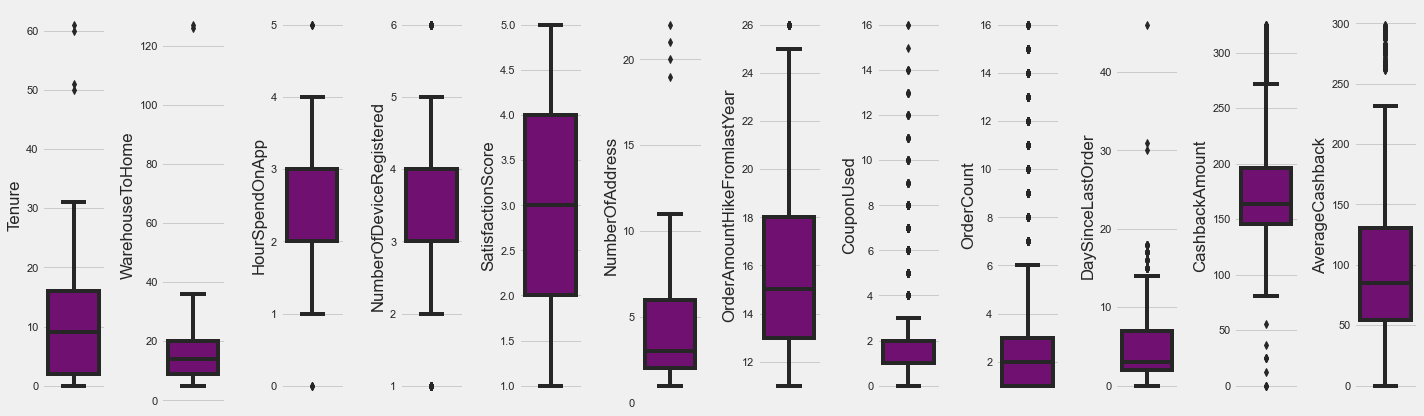

In [23]:
plt.figure(figsize=(20,6))
for i in range(0, len(features_num)):
    plt.subplot(1, len(features_num), i+1)
    sns.boxplot(y=df[features_num[i]], color='purple', orient='v')
    plt.tight_layout()

In [24]:
# Fill null values using median
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median())
df['NumberOfDeviceRegistered'] = df['NumberOfDeviceRegistered'].fillna(df['NumberOfDeviceRegistered'].median())
df['SatisfactionScore'] = df['SatisfactionScore'].fillna(df['SatisfactionScore'].mean())
df['NumberOfAddress'] = df['NumberOfAddress'].fillna(df['NumberOfAddress'].median())
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median())
df['CouponUsed'] = df['CouponUsed'].fillna(df['CouponUsed'].median())
df['OrderCount'] = df['OrderCount'].fillna(df['OrderCount'].median())
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())
df['CashbackAmount'] = df['CashbackAmount'].fillna(df['CashbackAmount'].median())
df['AverageCashback'] = df['AverageCashback'].fillna(df['AverageCashback'].median())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5630 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5630 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5630 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  OrderAmountHikeFro

#### <font color='yellow'>Duplicate Values</font>



In [25]:
df.duplicated(subset=features).sum()

558

In [26]:
pd.concat(i for _, i in df.groupby(features) if len(i) > 1)

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
257       1     0.0             Computer         1              9.0   
1727      1     0.0             Computer         1              9.0   
18        1     0.0             Computer         1             13.0   
1456      1     0.0             Computer         1             13.0   
607       1     0.0             Computer         1             14.0   
...     ...     ...                  ...       ...              ...   
4468      0    31.0             Computer         1              7.0   
4000      0    31.0             Computer         1             22.0   
5470      0    31.0             Computer         1             22.0   
3364      0    31.0         Mobile Phone         1             12.0   
4834      0    31.0         Mobile Phone         1             12.0   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
257      Cash on Delivery    Male             3.0                         3   
1727     Cash on Delivery    Male             3.0                         3   
18             Debit Card    Male             3.0                         5   
1456           Debit Card    Male             3.0                         5   
607           Credit Card  Female             2.0                         3   
...                   ...     ...             ...                       ...   
4468           Debit Card    Male             3.0                         6   
4000           Debit Card    Male             3.0                         4   
5470           Debit Card    Male             3.0                         4   
3364     Cash on Delivery  Female             3.0                         5   
4834     Cash on Delivery  Female             3.0                         5   

        PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
257               Mobile                  5        Single                1   
1727              Mobile                  5        Single                1   
18    Laptop & Accessory                  3        Single                2   
1456  Laptop & Accessory                  3        Single                2   
607               Mobile                  4        Single                1   
...                  ...                ...           ...              ...   
4468  Laptop & Accessory                  3       Married                4   
4000             Grocery                  3       Married                4   
5470             Grocery                  3       Married                4   
3364             Fashion                  4       Married                4   
4834             Fashion                  4       Married                4   

      OrderAmountHikeFromlastYear  CouponUsed  OrderCount  DaySinceLastOrder  \
257                          22.0         0.0         1.0                4.0   
1727                         22.0         0.0         1.0                4.0   
18                           24.0         1.0         1.0                6.0   
1456                         24.0         1.0         1.0                6.0   
607                          17.0         0.0         1.0                2.0   
...                           ...         ...         ...                ...   
4468                         14.0         2.0         2.0                3.0   
4000                         15.0         1.0         3.0                3.0   
5470                         15.0         1.0         3.0                3.0   
3364                         14.0         2.0         2.0                3.0   
4834                         14.0         2.0         2.0                3.0   

      CashbackAmount Complain_encoded  AverageCashback  
257           131.02               No           131.02  
1727          131.02               No           131.02  
18            160.74              Yes           160.74  
1456          160.74              Yes           160.74  
607           124.22 

In [27]:
df = df.drop_duplicates(subset=features, keep='first')

In [28]:
df.duplicated(subset=features).sum()

0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5072 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5072 non-null   int64  
 1   Tenure                       5072 non-null   float64
 2   PreferredLoginDevice         5072 non-null   object 
 3   CityTier                     5072 non-null   int64  
 4   WarehouseToHome              5072 non-null   float64
 5   PreferredPaymentMode         5072 non-null   object 
 6   Gender                       5072 non-null   object 
 7   HourSpendOnApp               5072 non-null   float64
 8   NumberOfDeviceRegistered     5072 non-null   int64  
 9   PreferedOrderCat             5072 non-null   object 
 10  SatisfactionScore            5072 non-null   int64  
 11  MaritalStatus                5072 non-null   object 
 12  NumberOfAddress              5072 non-null   int64  
 13  OrderAmountHikeFro

#### <font color='yellow'>Outliers</font>

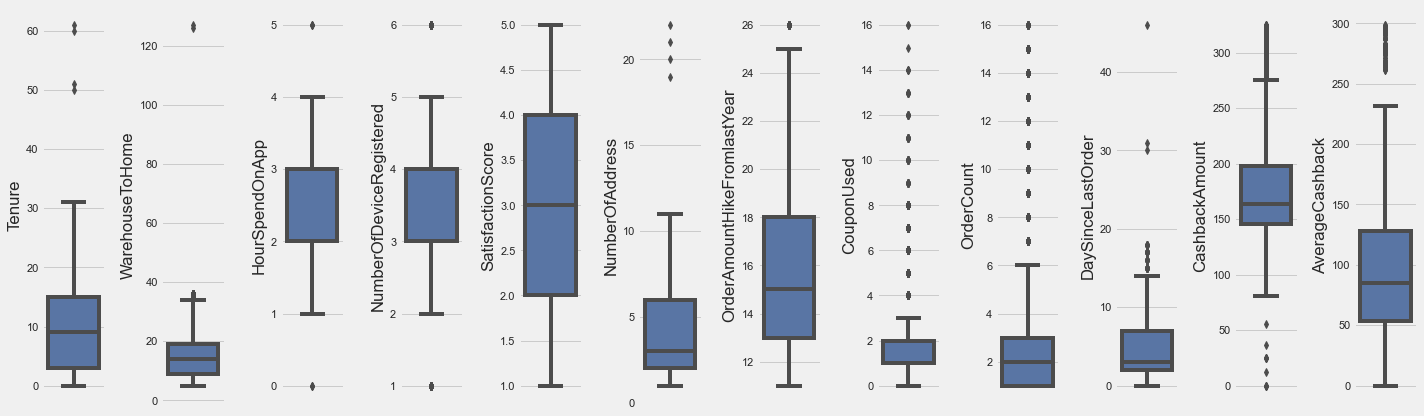

In [30]:
plt.figure(figsize=(20,6))
for i in range(0, len(features_num)):
    plt.subplot(1, len(features_num), i+1)
    sns.boxplot(y=df[features_num[i]], color='b', orient='v')
    plt.tight_layout()

In [31]:
# # Replacing outliers into upper or lower range values - 1
# def remove_outlier(col):
#     Q1,Q3 = np.percentile(col,[25,75])
#     IQR = Q3-Q1
#     lr = Q1-(1.5 * IQR) #lower range
#     ur = Q3+(1.5 * IQR) #upper range
#     return lr, ur

In [32]:
# # Replacing outliers into upper or lower range values - 2
# for column in features_num:
#     lr,ur = remove_outlier(df[column])
#     df[column] = np.where(df[column] > ur, ur, df[column])
#     df[column] = np.where(df[column] < lr, lr, df[column])

In [33]:
# print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

# filtered_entries = np.array([True] * len(df))
# for col in features_num:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     low_limit = Q1 - (IQR * 1.5)
#     high_limit = Q3 + (IQR * 1.5)

#     filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries
    
# df = df[filtered_entries]

# print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

In [34]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in features_num:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 5072
Jumlah baris setelah memfilter outlier: 4726


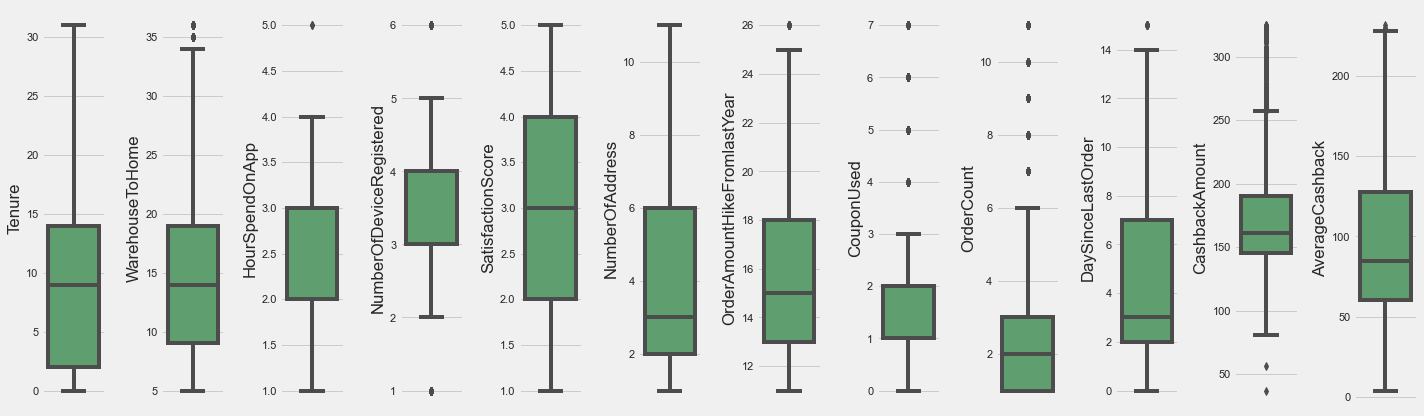

In [35]:
plt.figure(figsize=(20,6))
for i in range(0, len(features_num)):
    plt.subplot(1, len(features_num), i+1)
    sns.boxplot(y=df[features_num[i]], color='g', orient='v')
    plt.tight_layout()

#### <font color='yellow'>Normalization/Standardization</font>


In [36]:
# Scaling data to ensure no features dominate against the other
df[features_num].describe().T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

In [37]:
# Standardize for features with mean similar to its median
df['Tenure'] = StandardScaler().fit_transform(df['Tenure'].values.reshape(len(df), 1))
df['WarehouseToHome'] = StandardScaler().fit_transform(df['WarehouseToHome'].values.reshape(len(df), 1))
df['HourSpendOnApp'] = StandardScaler().fit_transform(df['HourSpendOnApp'].values.reshape(len(df), 1))
df['NumberOfDeviceRegistered'] = StandardScaler().fit_transform(df['NumberOfDeviceRegistered'].values.reshape(len(df), 1))
df['SatisfactionScore'] = StandardScaler().fit_transform(df['SatisfactionScore'].values.reshape(len(df), 1))
df['NumberOfAddress'] = StandardScaler().fit_transform(df['NumberOfAddress'].values.reshape(len(df), 1))
df['OrderAmountHikeFromlastYear'] = StandardScaler().fit_transform(df['OrderAmountHikeFromlastYear'].values.reshape(len(df), 1))
df['CouponUsed'] = StandardScaler().fit_transform(df['CouponUsed'].values.reshape(len(df), 1))
df['OrderCount'] = StandardScaler().fit_transform(df['OrderCount'].values.reshape(len(df), 1))
df['DaySinceLastOrder'] = StandardScaler().fit_transform(df['DaySinceLastOrder'].values.reshape(len(df), 1))
df['CashbackAmount'] = StandardScaler().fit_transform(df['CashbackAmount'].values.reshape(len(df), 1))
df['AverageCashback'] = StandardScaler().fit_transform(df['AverageCashback'].values.reshape(len(df), 1))

df[features_num].describe().T.style.background_gradient(cmap='viridis',low=0.3,high=0.1)

#### <font color='yellow'>Feature encoding</font>

In [38]:
df_cat.describe().T

count unique                 top  freq
PreferredLoginDevice  5630      2        Mobile Phone  3996
PreferredPaymentMode  5630      5          Debit Card  2314
Gender                5630      2                Male  3384
PreferedOrderCat      5630      6  Laptop & Accessory  2050
MaritalStatus         5630      3             Married  2986
Complain_encoded      5630      2                  No  4026
CityTier              5630      3                   1  3666

In [39]:
df_encoded = df
for category in cat:
    onehots = pd.get_dummies(df_encoded[category], prefix=category)
    df_encoded = df_encoded.join(onehots)

# df_encoded.info()

In [40]:
df_encoded = df_encoded.drop(columns=cat)

In [41]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4726 entries, 0 to 5629
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  4726 non-null   int64  
 1   Tenure                                 4726 non-null   float64
 2   WarehouseToHome                        4726 non-null   float64
 3   HourSpendOnApp                         4726 non-null   float64
 4   NumberOfDeviceRegistered               4726 non-null   float64
 5   SatisfactionScore                      4726 non-null   float64
 6   NumberOfAddress                        4726 non-null   float64
 7   OrderAmountHikeFromlastYear            4726 non-null   float64
 8   CouponUsed                             4726 non-null   float64
 9   OrderCount                             4726 non-null   float64
 10  DaySinceLastOrder                      4726 non-null   float64
 11  Cash

#### <font color='yellow'>Class imbalance</font>

In [42]:
df['Churn'].value_counts()

0    3923
1     803
Name: Churn, dtype: int64

In [43]:
X = df_encoded[[col for col in df_encoded.columns if (str(df_encoded[col].dtype) != 'object') and col not in ['Churn']]]
y = df_encoded['Churn'].values
print(X.shape)
print(y.shape)

(4726, 35)
(4726,)


In [44]:
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(1).fit_resample(X, y)

In [45]:
print('Original')
print(pd.Series(y).value_counts())
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
0    3923
1     803
dtype: int64
SMOTE
0    3923
1    3923
dtype: int64


In [46]:
X_over_SMOTE=pd.DataFrame(X_over_SMOTE)
#Renaming column name of Target variable
y_over_SMOTE=pd.DataFrame(y_over_SMOTE)
y_over_SMOTE.columns = ['churn_SMOTE']
df_clean = pd.concat([X_over_SMOTE,y_over_SMOTE], axis=1)

In [47]:
df_clean.sample(5)

Tenure  WarehouseToHome  HourSpendOnApp  NumberOfDeviceRegistered  \
927  -0.080873        -0.430829        0.091034                 -2.594982   
7183 -1.093945         0.001274       -0.263181                  0.067344   
341  -1.186224        -0.924279        0.091034                 -0.659700   
4684 -0.694957        -0.924279        1.515624                  0.307942   
4958 -1.186224        -0.377126        0.091034                 -0.659700   

      SatisfactionScore  NumberOfAddress  OrderAmountHikeFromlastYear  \
927            1.433578        -0.067234                    -0.747652   
7183          -0.735839        -0.558266                    -0.258656   
341            1.433578        -1.246991                    -1.306072   
4684           0.710439        -0.460486                    -0.468442   
4958           1.118779        -0.631678                    -1.062979   

      CouponUsed  OrderCount  DaySinceLastOrder  ...  PreferedOrderCat_Others  \
927    -0.393436   -0.770833          -0.694119  ...                        0   
7183   -0.564161   -0.419690          -0.463466  ...                        0   
341    -1.080061   -0.770833          -0.694119  ...                        0   
4684    0.293189   -0.303488           1.147771  ...                        0   
4958   -1.080061   -0.770833          -0.788045  ...                        0   

      MaritalStatus_Divorced  MaritalStatus_Married  MaritalStatus_Single  \
927                        0                      1                     0   
7183                       0                      0                     1   
341                        0                      1                     0   
4684                       0                      1                     0   
4958                       0                      0                     1   

      Complain_encoded_No  Complain_encoded_Yes  CityTier_1  CityTier_2  \
927                     0                     1           1           0   
7183                    0                     1           0           0   
341                     1                     0           0           0   
4684                    1                     0           1           0   
4958                    1                     0           0           0   

      CityTier_3  churn_SMOTE  
927            0            0  
7183           1            1  
341            1            1  
4684           0            0  
4958           0            1  

[5 rows x 36 columns]

In [48]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7846 entries, 0 to 7845
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Tenure                                 7846 non-null   float64
 1   WarehouseToHome                        7846 non-null   float64
 2   HourSpendOnApp                         7846 non-null   float64
 3   NumberOfDeviceRegistered               7846 non-null   float64
 4   SatisfactionScore                      7846 non-null   float64
 5   NumberOfAddress                        7846 non-null   float64
 6   OrderAmountHikeFromlastYear            7846 non-null   float64
 7   CouponUsed                             7846 non-null   float64
 8   OrderCount                             7846 non-null   float64
 9   DaySinceLastOrder                      7846 non-null   float64
 10  CashbackAmount                         7846 non-null   float64
 11  Aver

In [49]:
df_clean.describe().T.style.background_gradient(cmap='viridis',low=0.3,high=0.1)

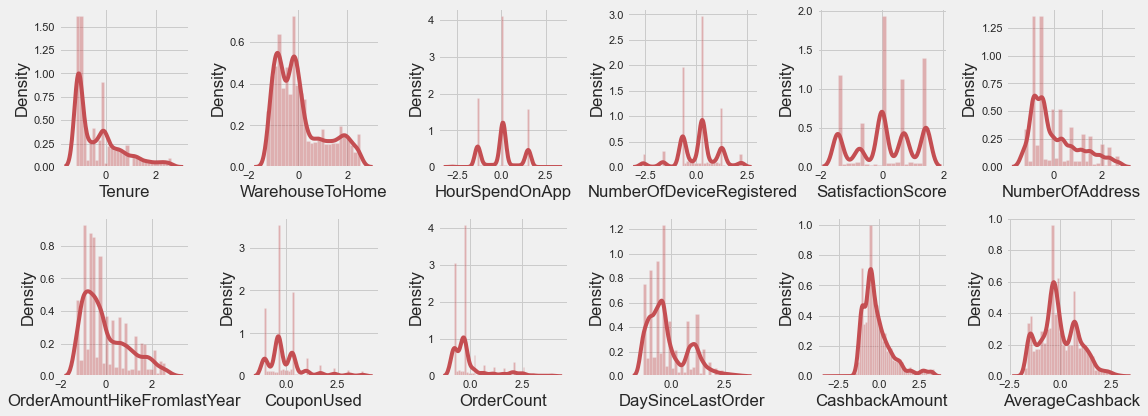

In [50]:
plt.figure(figsize=(16, 6))
for i in range(0, len(features_num)):
    plt.subplot(2, len(features_num)/2, i+1)
    sns.distplot(df_clean[features_num[i]], color='r')
    plt.tight_layout()    

# <font color='orangered'>Stage 2</font>

#### <font color='yellow'>Univariate Analysis</font>

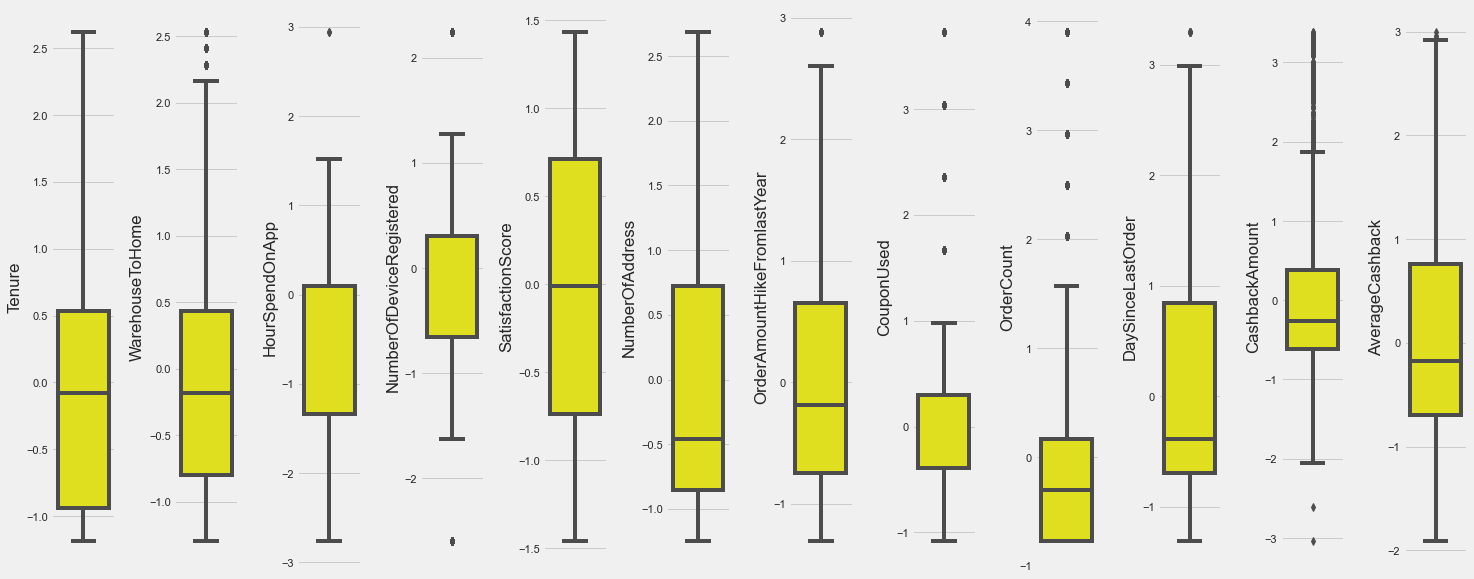

In [51]:
for i in range(0, len(features_num)):
    plt.subplot(1, len(features_num), i+1)
    sns.boxplot(y=df[features_num[i]], color='yellow', orient='v')
    plt.tight_layout()

* Outlier terlihat utamanya pada kolom `CouponUsed`, `OrderCount`, dan `CashbackAmount`
* Dari boxplotnya terlihat mana distribusi yang terlihat cenderung *normal*: `HourSpendOnApp`, `NumberOfDeviceRegistered`, dan `SatisfactionScore` (selain itu terlihat *skewed*)

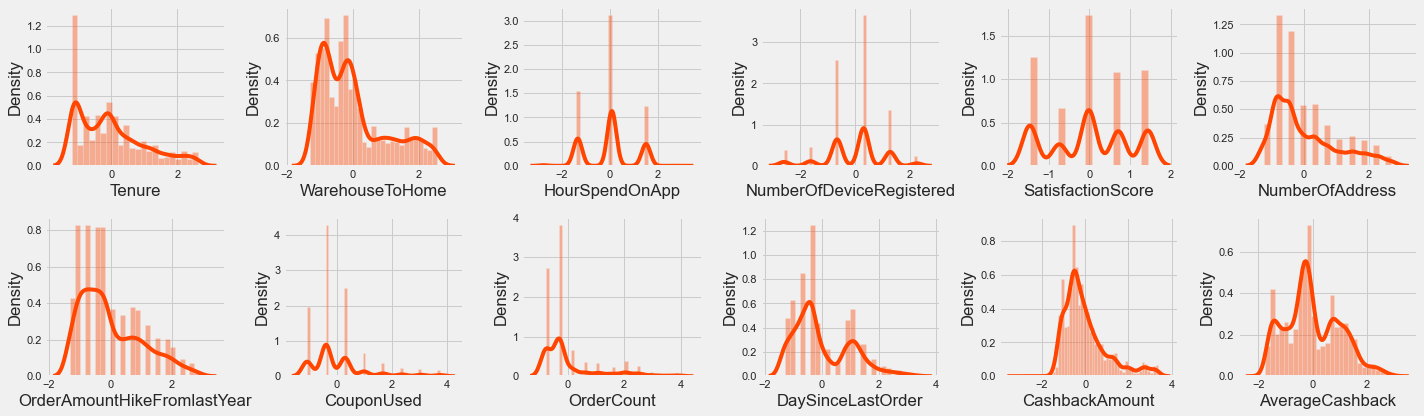

In [52]:
plt.figure(figsize=(20, 6))
for i in range(0, len(features_num)):
    plt.subplot(2, len(features_num)/2, i+1)
    sns.distplot(df[features_num[i]], color='orangered')
    plt.tight_layout()

* Dari distplot kita dapat melihat lebih jelas kolom-kolom yang memiliki distribusi yang cenderung normal yaitu: `HourSpendOnApp`, `NumberOfDeviceRegistered`, dan `SatisfactionScore` 

#### <font color='yellow'>Bivariate Analysis</font>

##### <font color='orangered'>Numerical X Target </font>

<AxesSubplot:>

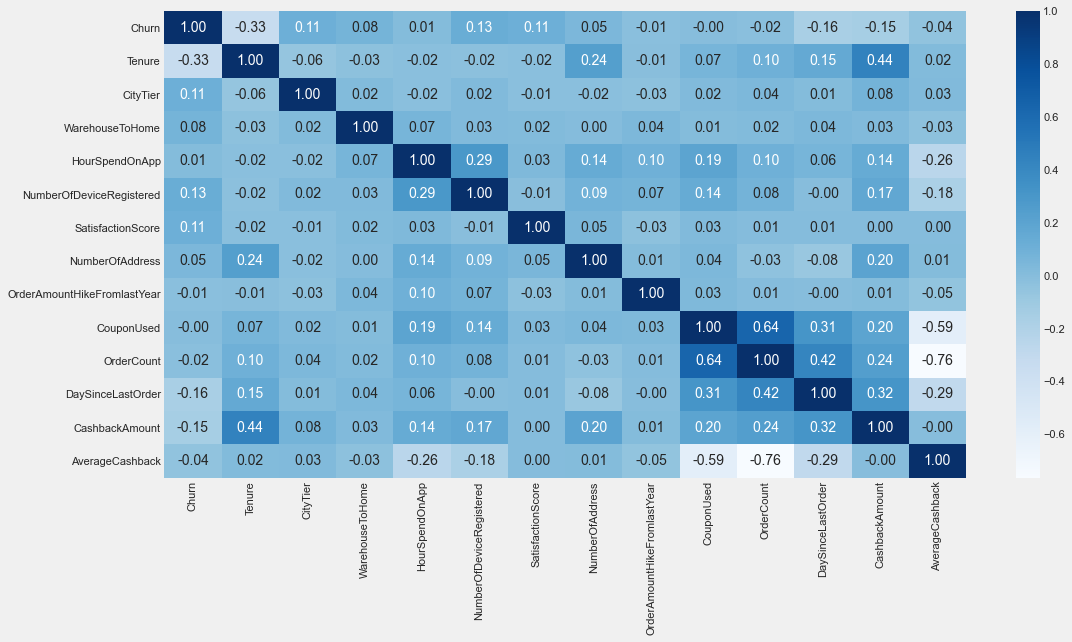

In [53]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')

* Target `Churn` memiliki korelasi negatif lemah dengan `Tenure`, `DaySinceLastOrder`, dan `CashbackAmount`
* Target `Churn` juga memiliki korelasi positif lemah dengan `NumberOfDeviceRegistered` dan `SatisfactionScore` <br> <br>
* Feature `CouponUsed` dan `OrderCount` memiliki korelasi positif kuat, bisa jadi feature ini redundan
* Feature `CashbackAmount` dan `Tenure` memiliki korelasi positif lemah, begitu juga dengan `DaySinceLastOrder` dan `OrderCount`

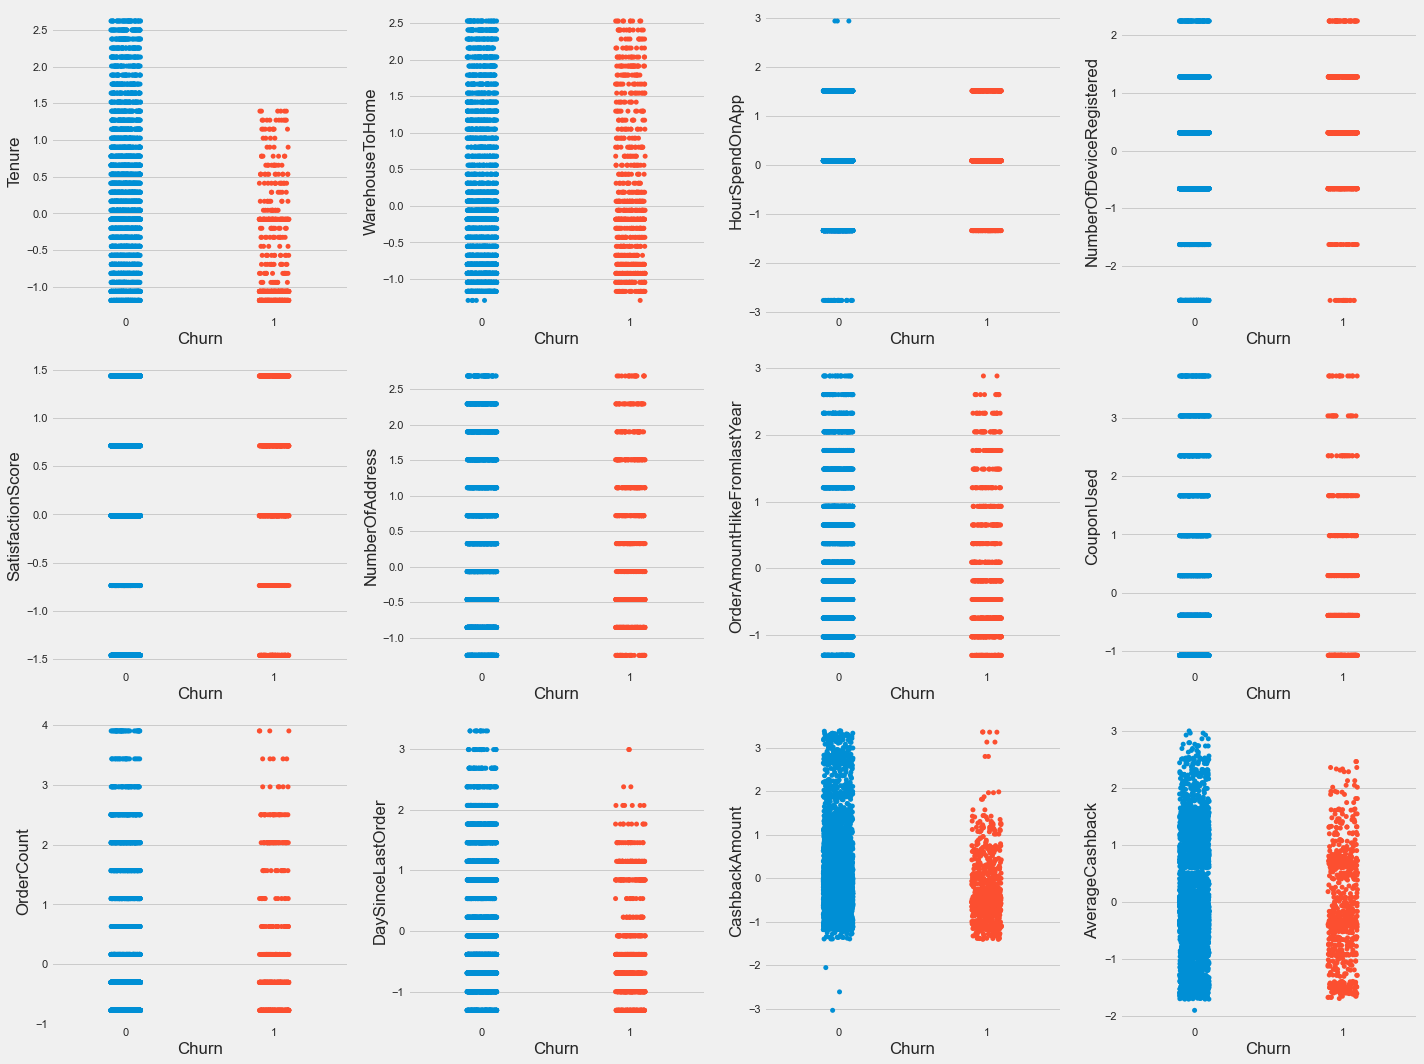

In [54]:
fig = plt.figure(figsize=(20, 15))
for i in range(0, len(features_num)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 4, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df, x='Churn', y=features_num[i]) # gambar catplot/stripplotnya
    plt.tight_layout() # layout

    #if i != 0: plt.close(i+1) # close figure 

    #plt.close(len(nums) + 1) # close figure 

* Customer dengan `Tenure` rendah cenderung untuk churn, artinya pelanggan yang sudah lama menggunakan layanan E-Commerce XYZ cenderung untuk tidak churn
* Customer dengan `HourSpendOnApp` sangat tinggi dan sangat rendah cenderung untuk tidak churn. <br>
* Semakin tinggi `CashbackAmount` dan `AverageCashback`, customer cenderung untuk tidak churn. Artinya, kedua feature ini cukup efektif untuk mengurangi churn rate.

##### <font color='orangered'>Categorical X Target </font>

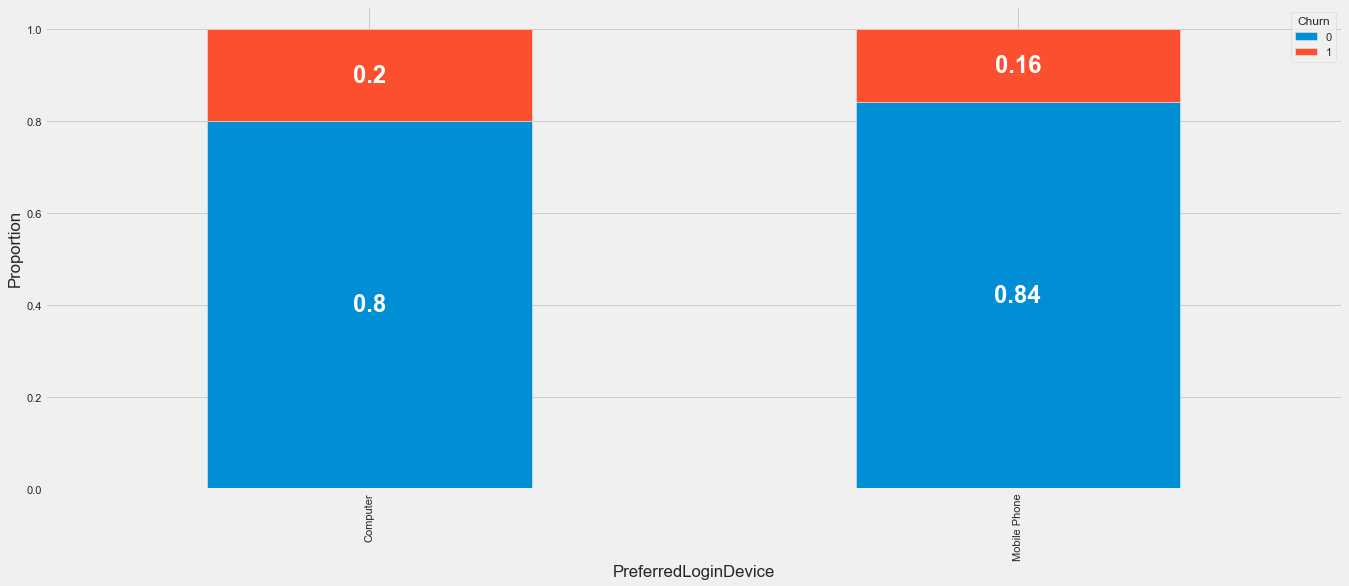

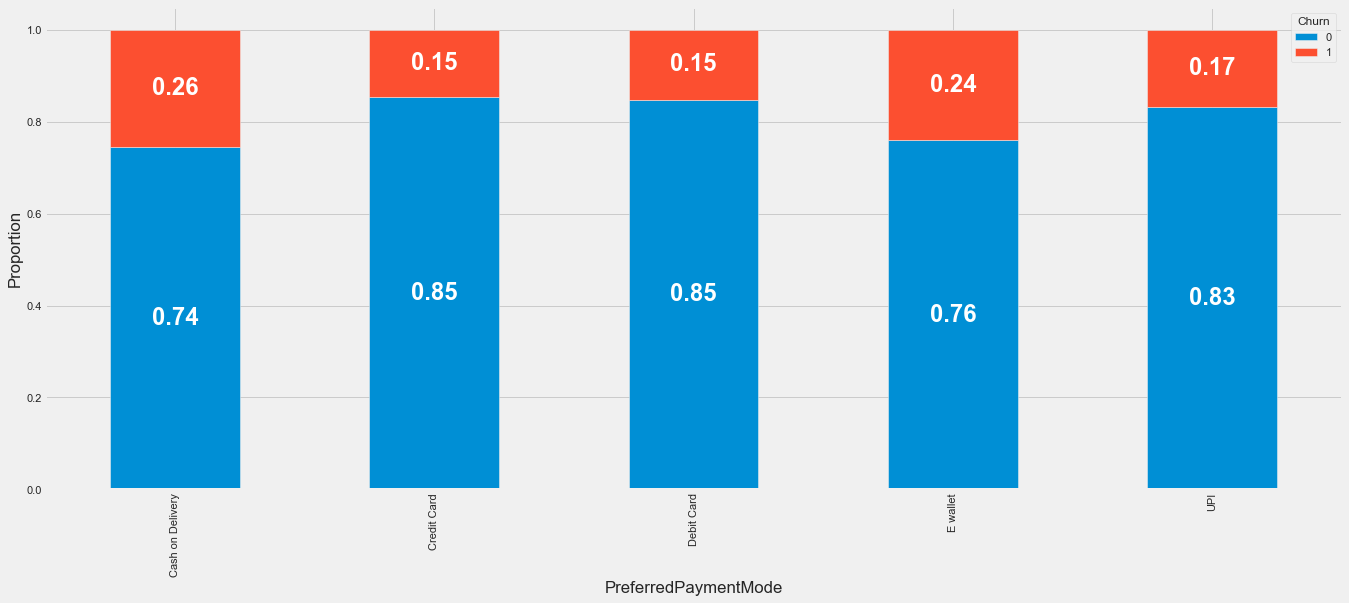

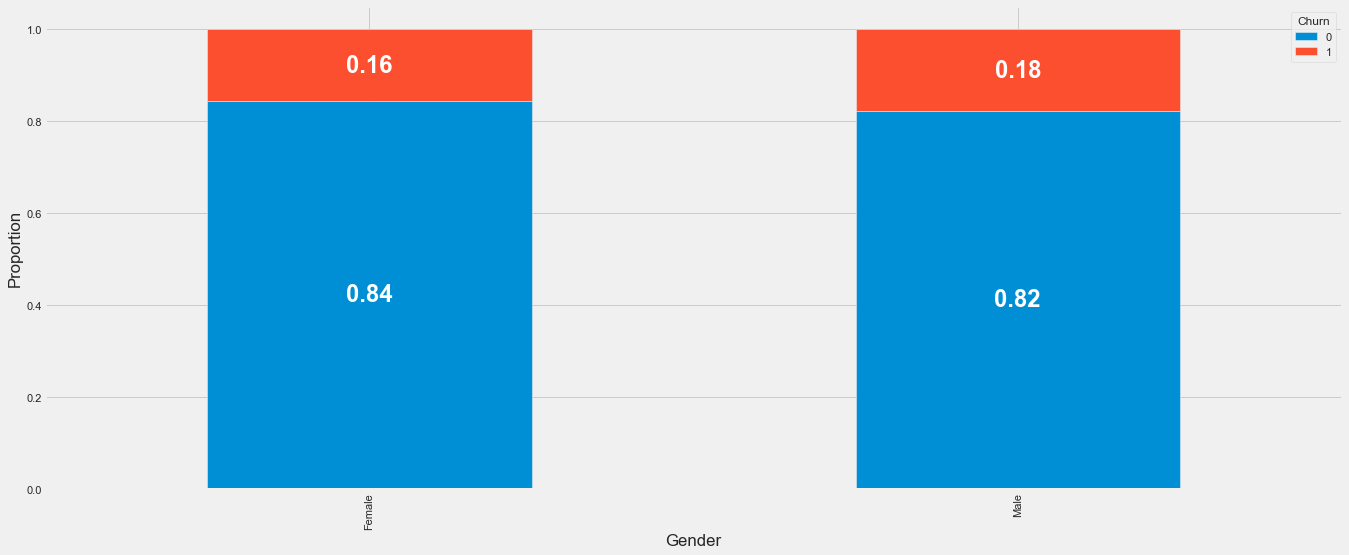

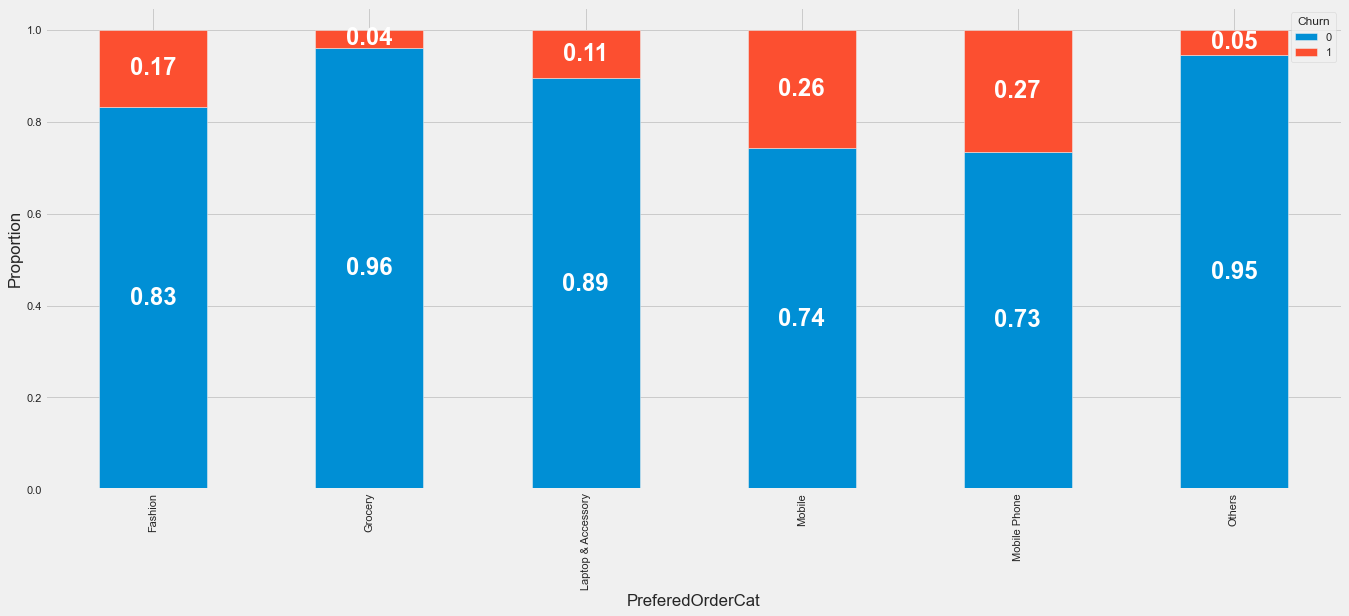

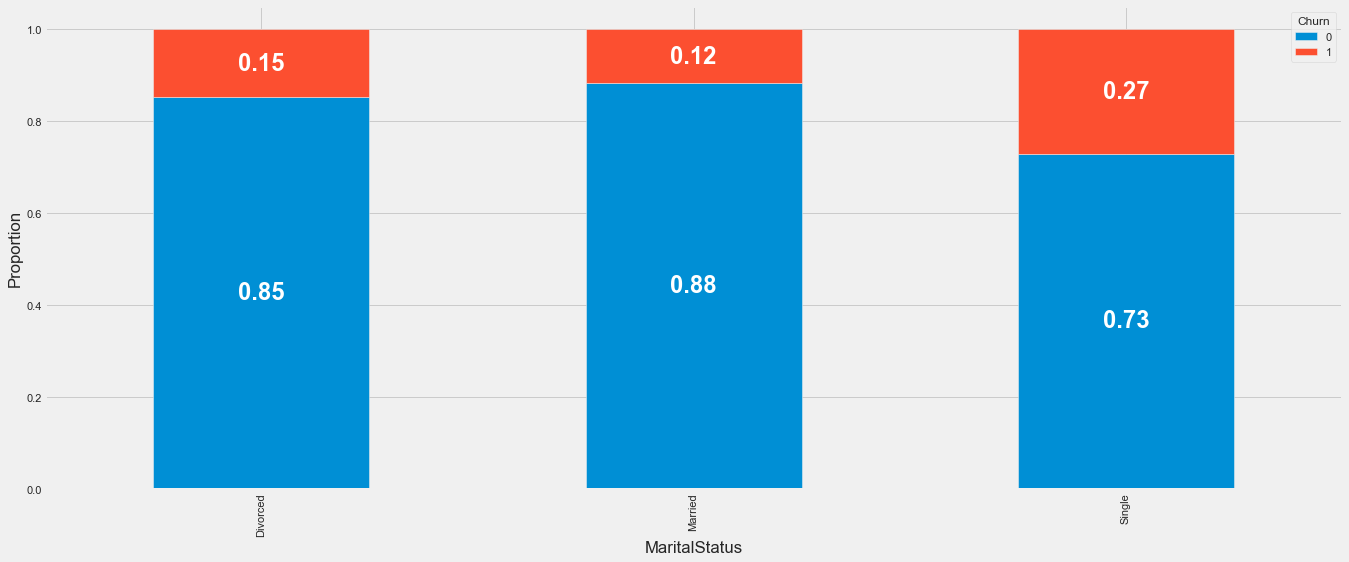

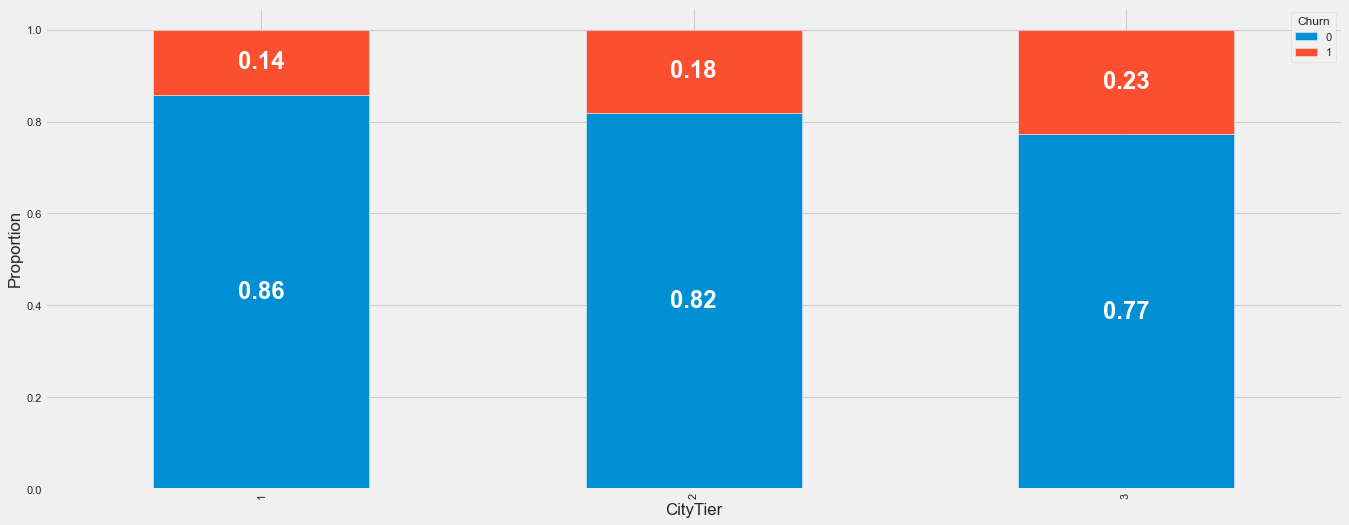

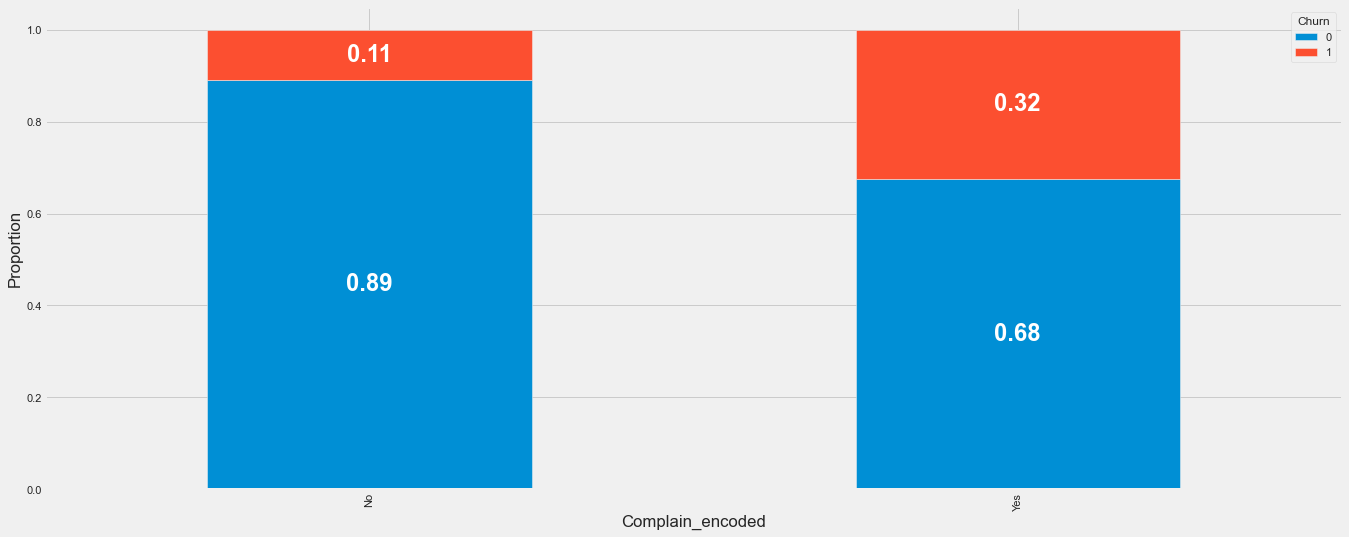

In [55]:
for i in range(0, len(features_cat)): # untuk setiap kolom categorical
    ax = df.groupby(df[features_cat[i]])['Churn'].value_counts(normalize=True).unstack('Churn').plot.bar(stacked=True)
    ax.set_ylabel('Proportion')
    
    for c in ax.containers:

        # Optional: if the segment is small or 0, customize the labels
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]

        # remove the labels parameter if it's not needed for customized labels
        ax.bar_label(c, labels=np.round(labels, 2), label_type='center', color = 'white', weight = 'bold', fontsize = 24)

* `PreferredLoginDevice` terlihat tidak memiliki korelasi dengan target.
* `PreferredPaymentMode` kategori _Cash on Delivery_ dan _E Wallet_ cenderung memiliki persentase churn yang lebih tinggi dibandingkan kategori lain. Bisa jadi disebabkan mode pembayaran yang lain lebih mudah diakses daripada kedua kategori tersebut (Ex: COD perlu uang tunai dari ATM; E-Wallet perlu top up dahulu)
* `Gender` terlihat tidak memiliki korelasi dengan target.
* `PreferedOrderCat` terlihat memiliki korelasi dengan target, terutama pada kategori _Mobile_ dan _Mobile Phone_. Pada kedua kategori tersebut, persentase churn cenderung tinggi. Hal ini bisa jadi disebabkan karena customer jarang membeli produk _Mobile_ atau _Mobile Phone_ secara rutin. 
* `MaritalStatus` kategori _Single_ cenderung memiliki persentase churn yang lebih tinggi. Bisa jadi disebabkan orang yang single lebih sedikit kebutuhan barang yang harus dibeli dibandingkan orang yang sudah menikah atau sudah bercerai (dan mungkin memiliki anak).
* `CityTier` kategori _3_ cenderung memiliki persentase churn yang lebih tinggi. Bisa jadi disebabkan orang yang tinggal di kota kecil memiliki daya konsumsi yang lebih kecil dibandingkan orang yang tinggal di kota besar. (https://www.bappenas.go.id/files/2415/1814/3512/180206_NUDPS_Indonesia_WUF9_Bappenas.pdf [City Tier 1-4]; https://lokadata.id/artikel/inilah-kota-kota-dengan-belanja-non-pangan-tinggi-salah-satu-penanda-kesejahteraan [Daya konsumsi berdasarkan City]).
* `Complain_encoded` kategori _Yes_ memiliki persentase churn yang lebih tinggi, artinya orang yang pernah melakukan komplain cenderung untuk churn.

##### <font color='orangered'>Categorical X Numerical </font>

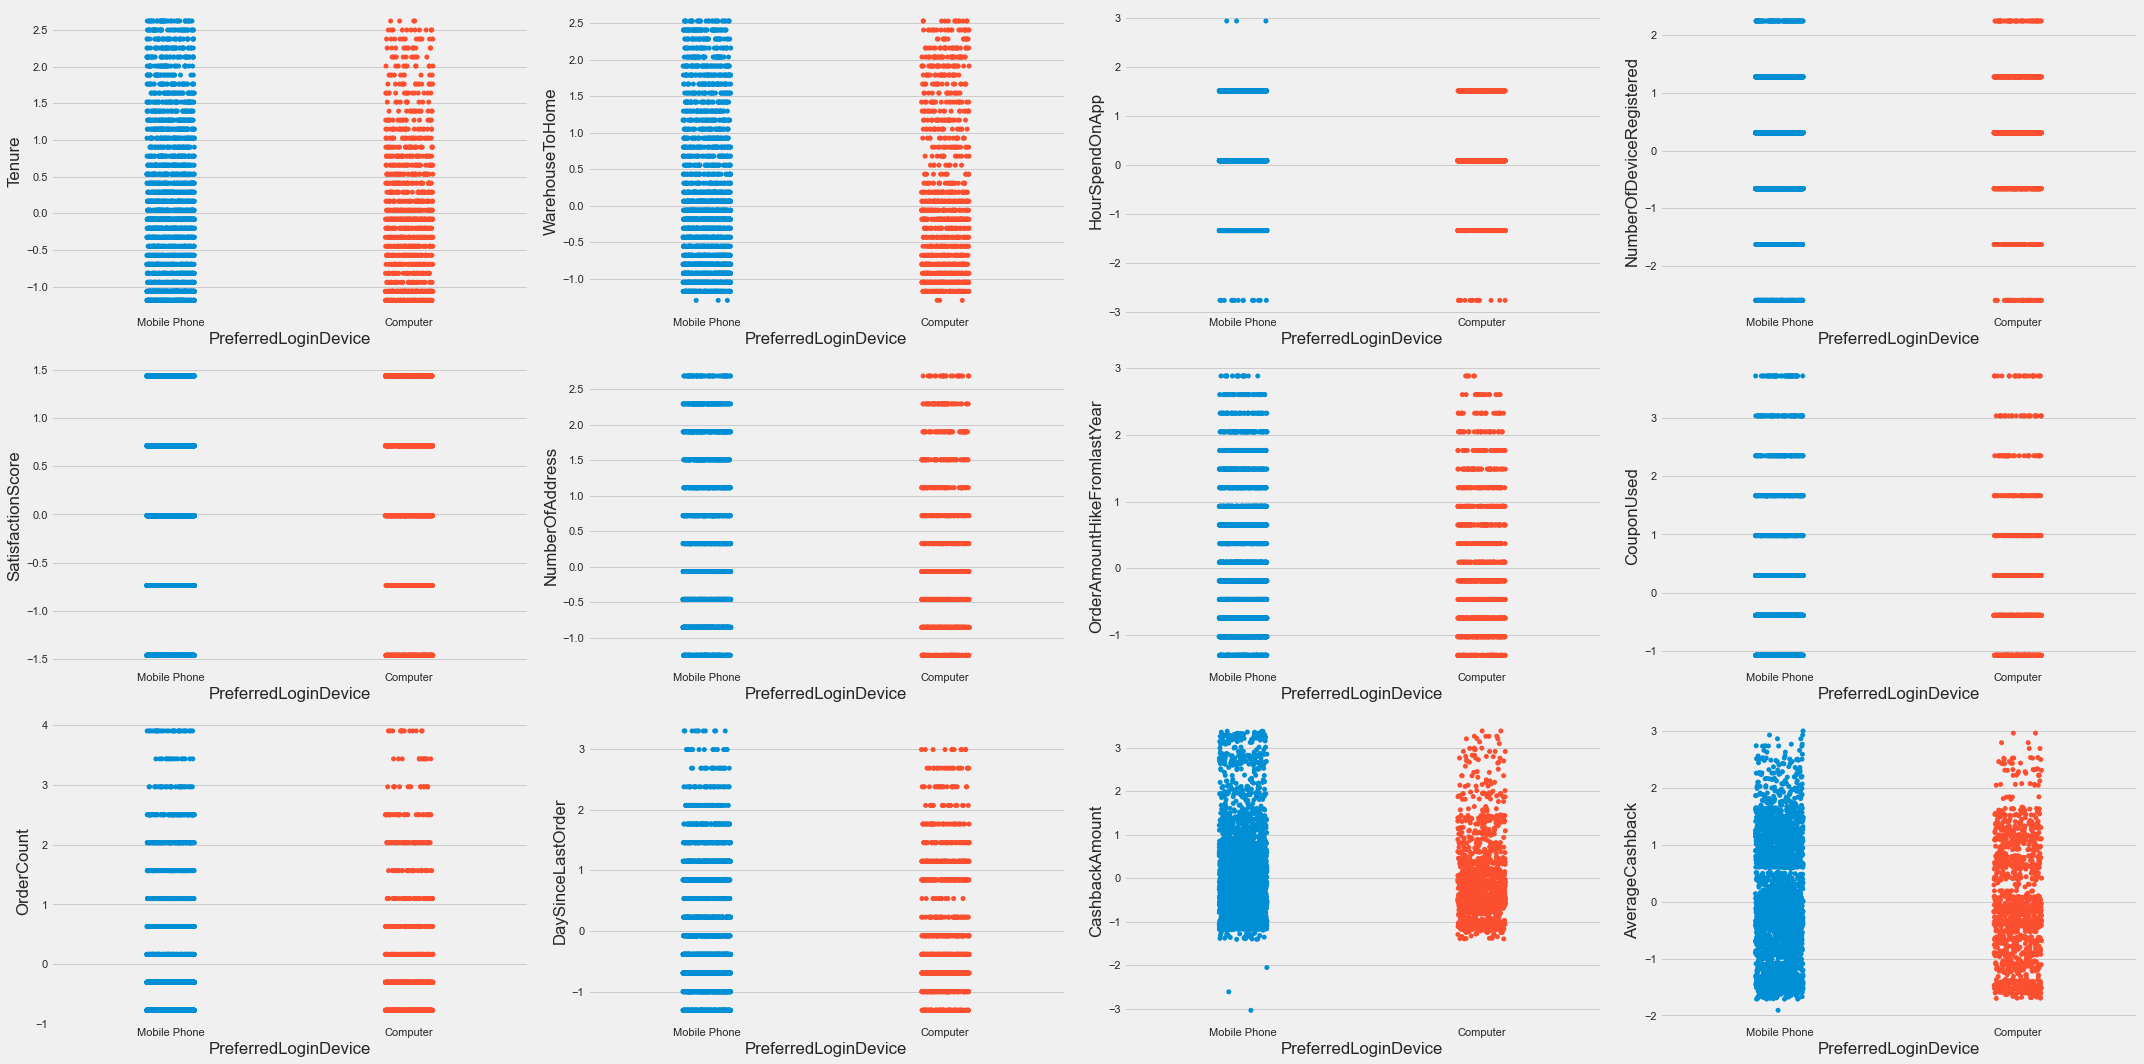

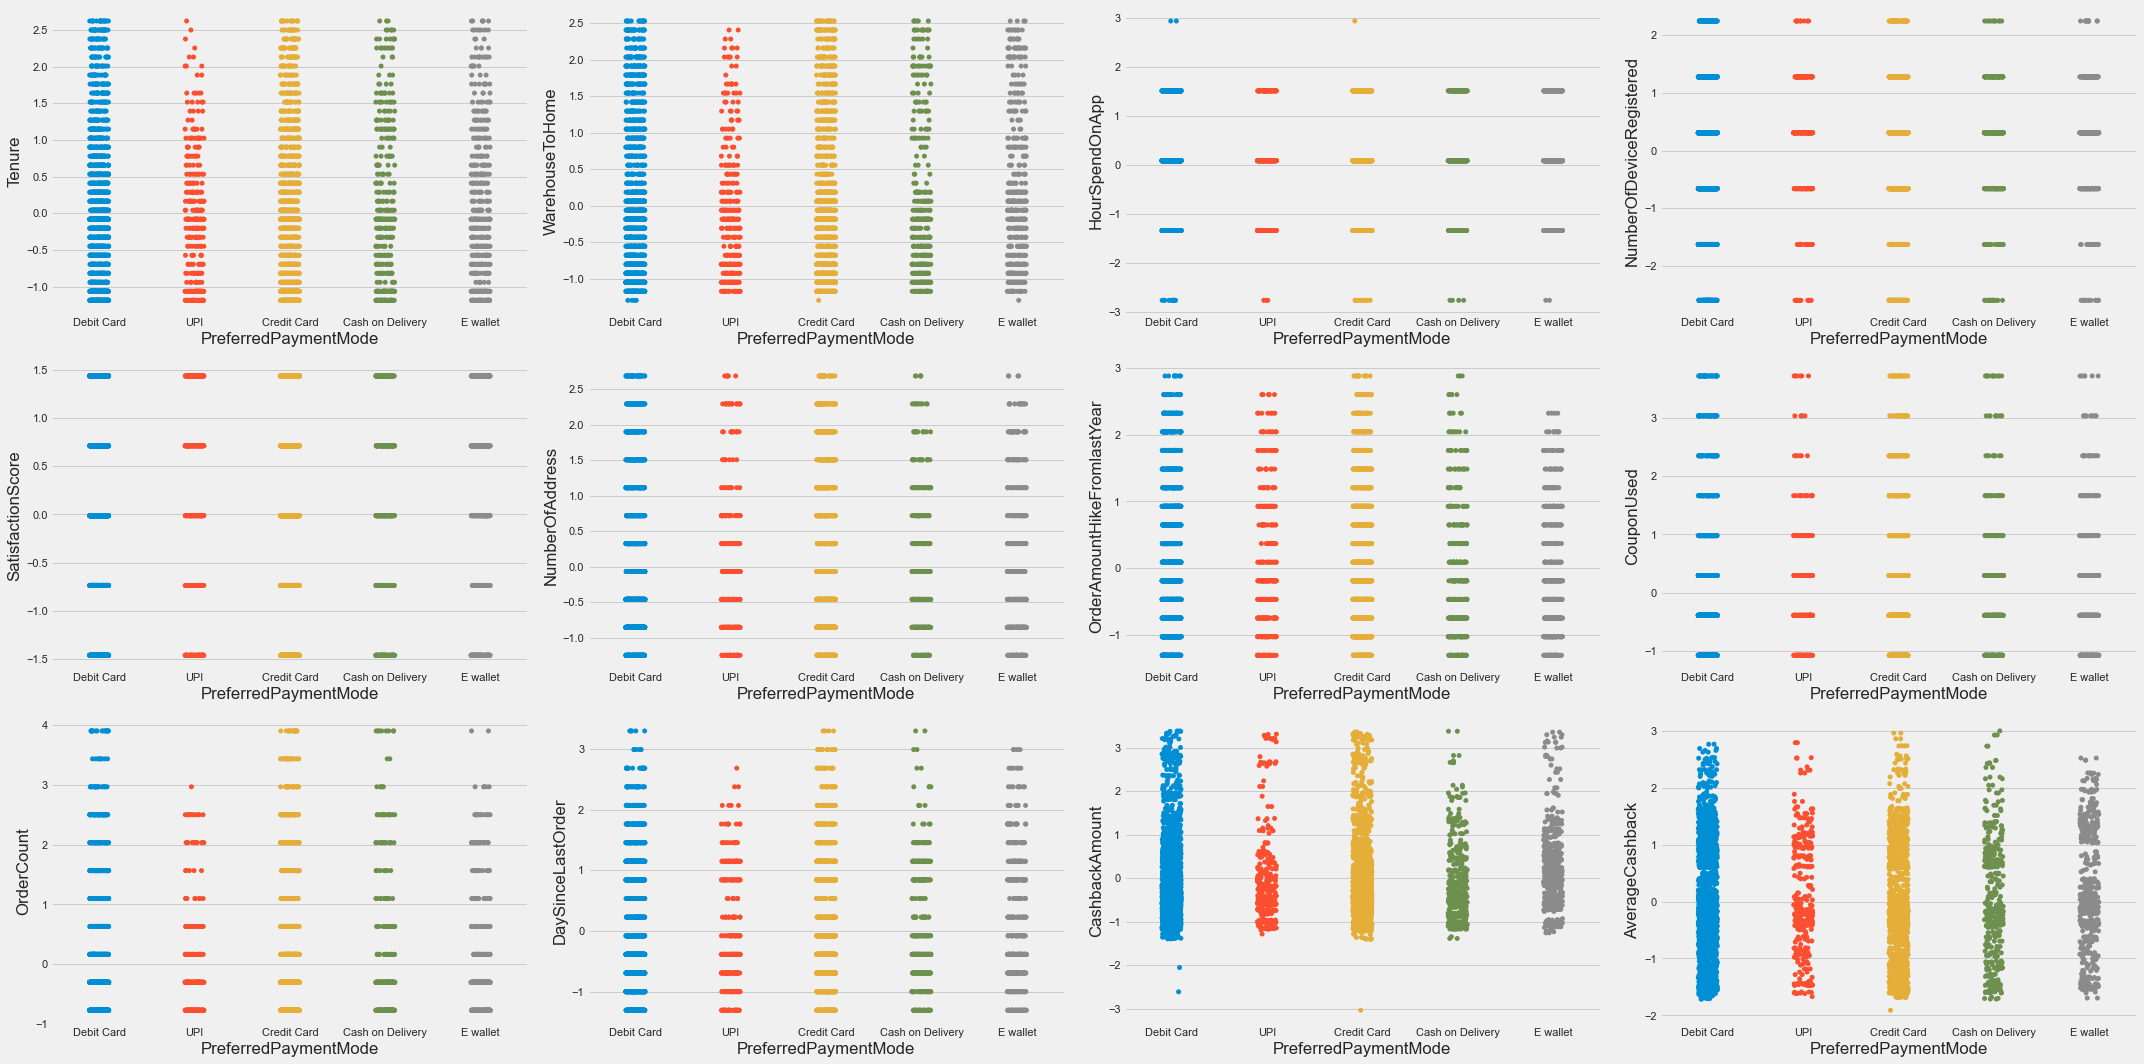

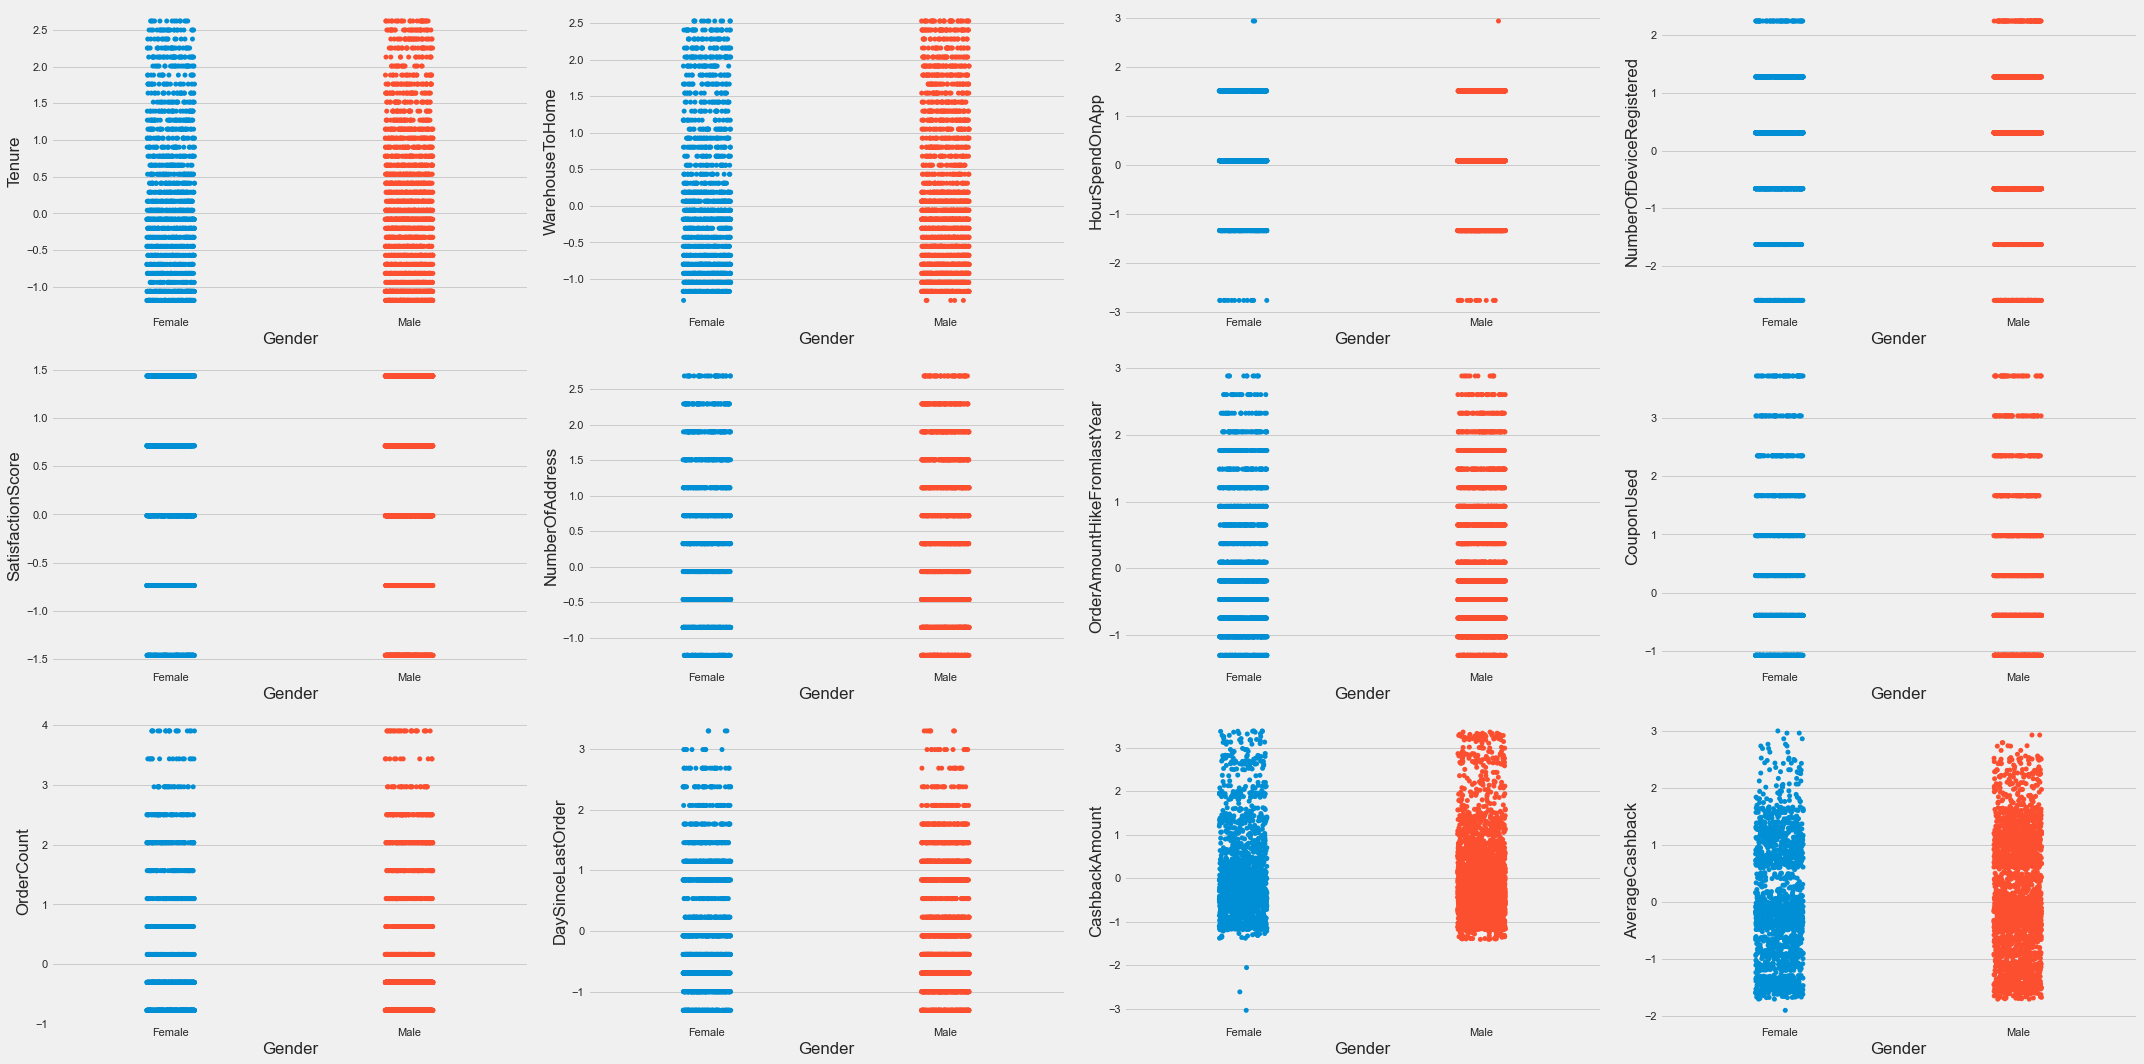

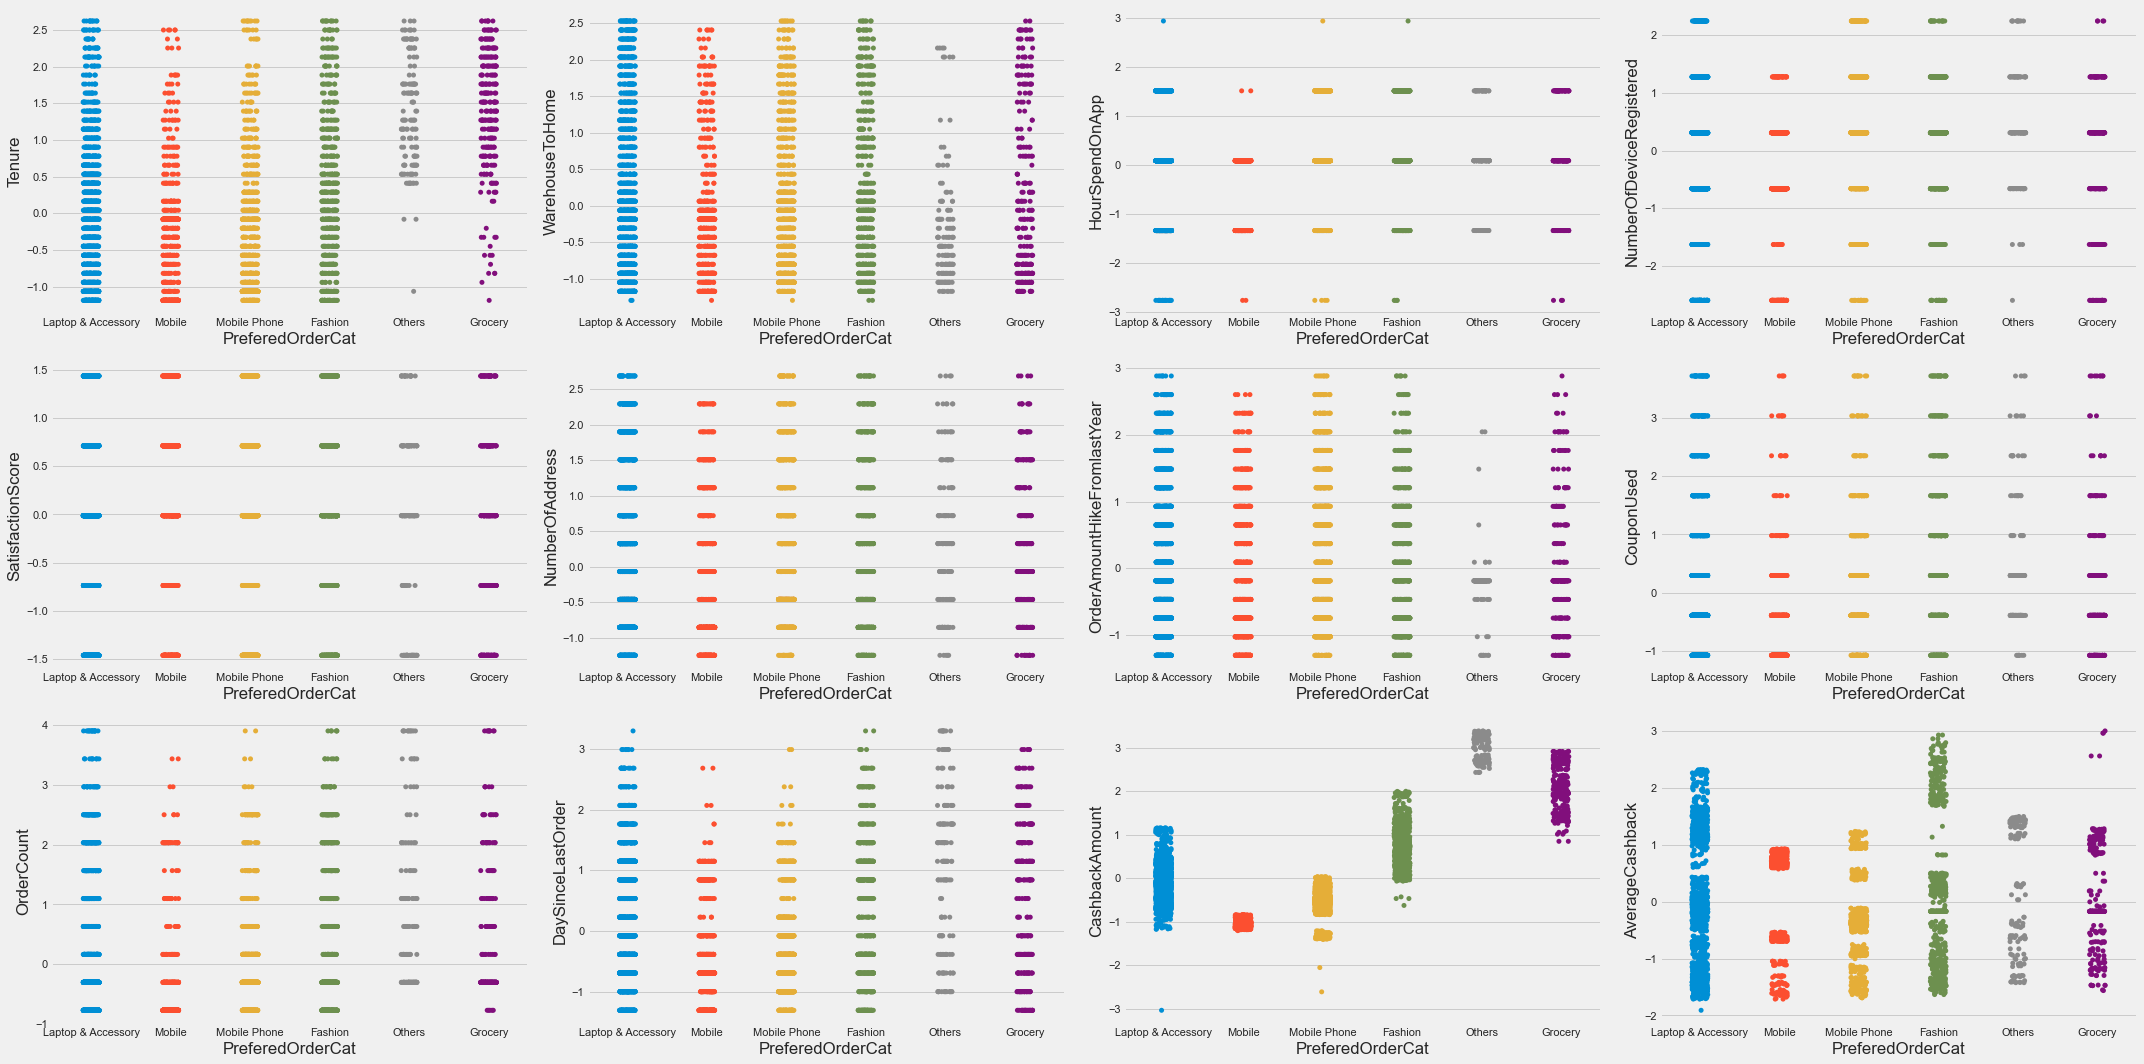

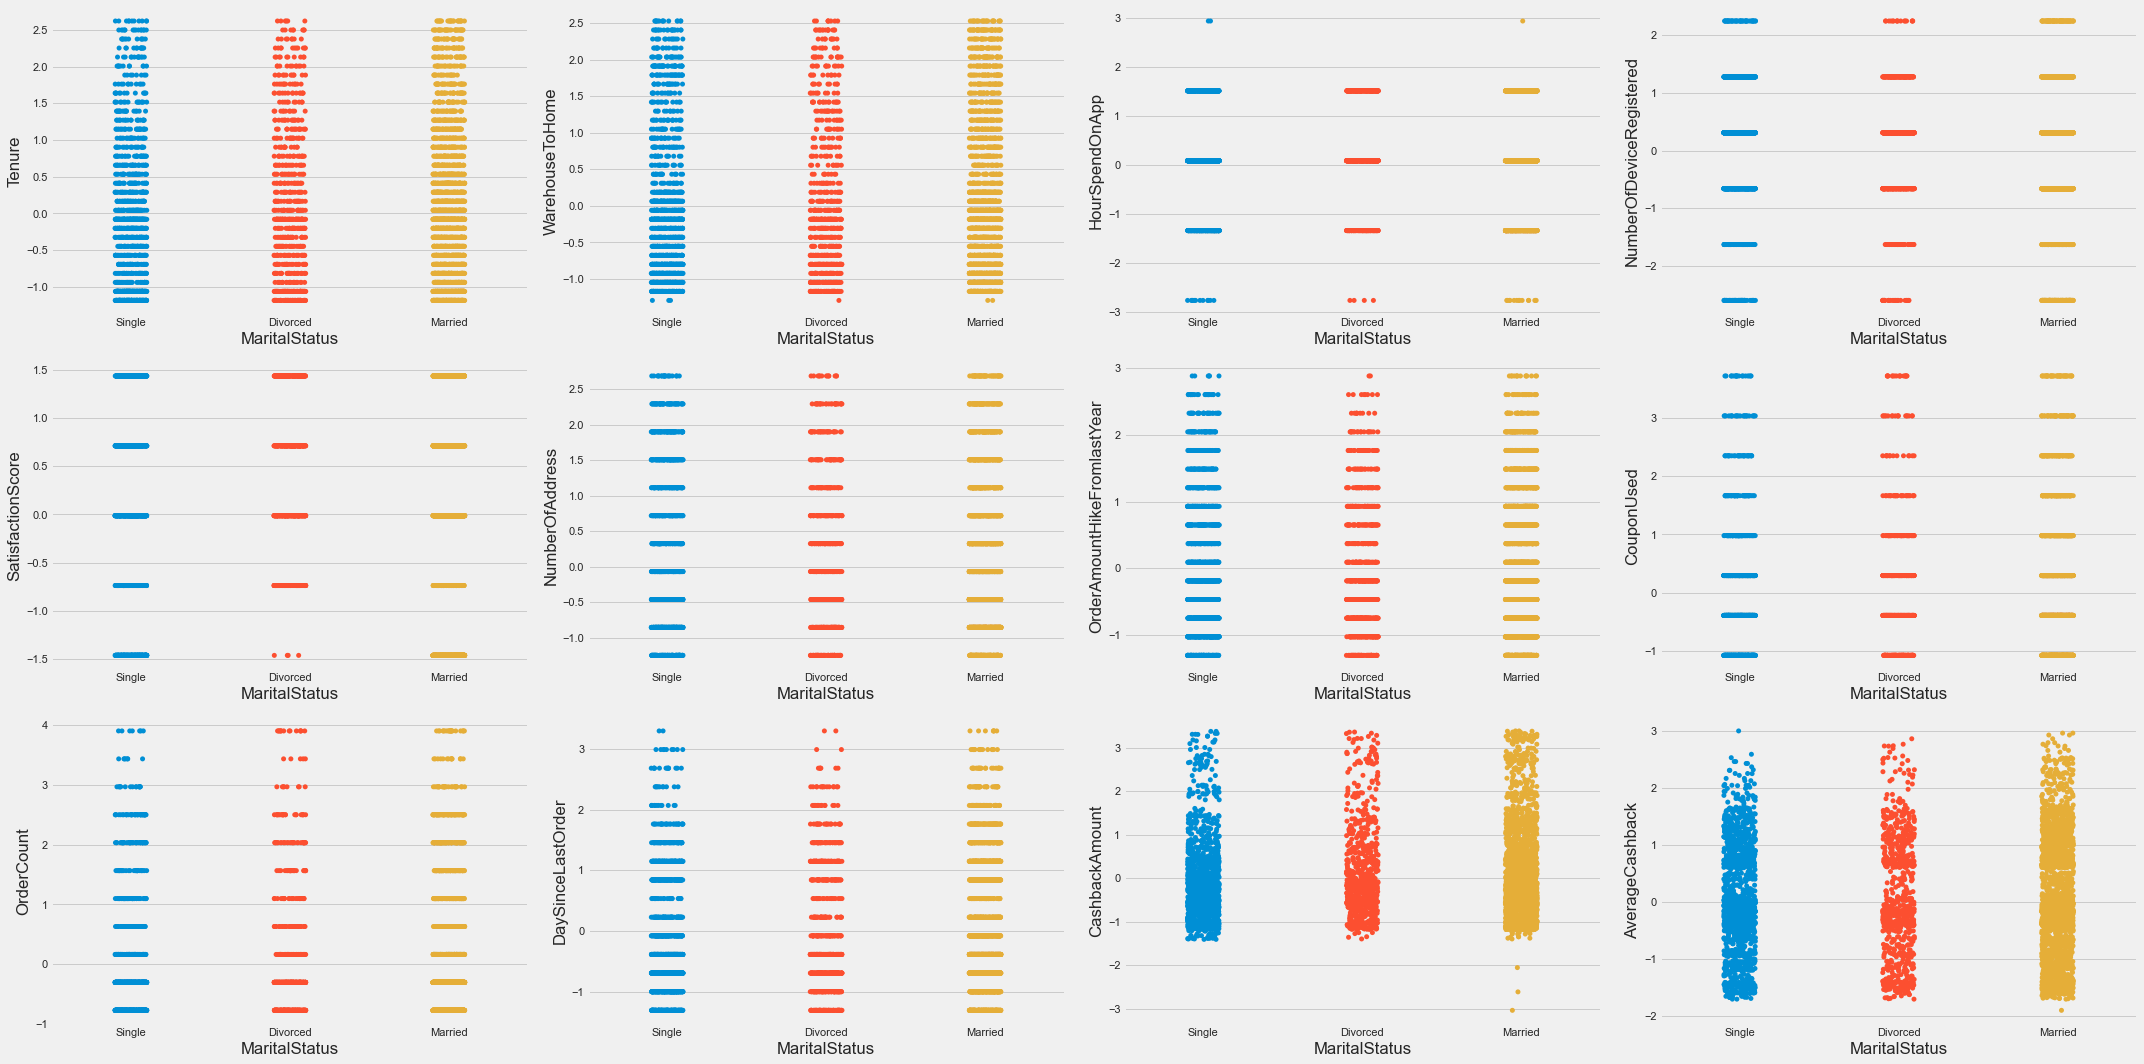

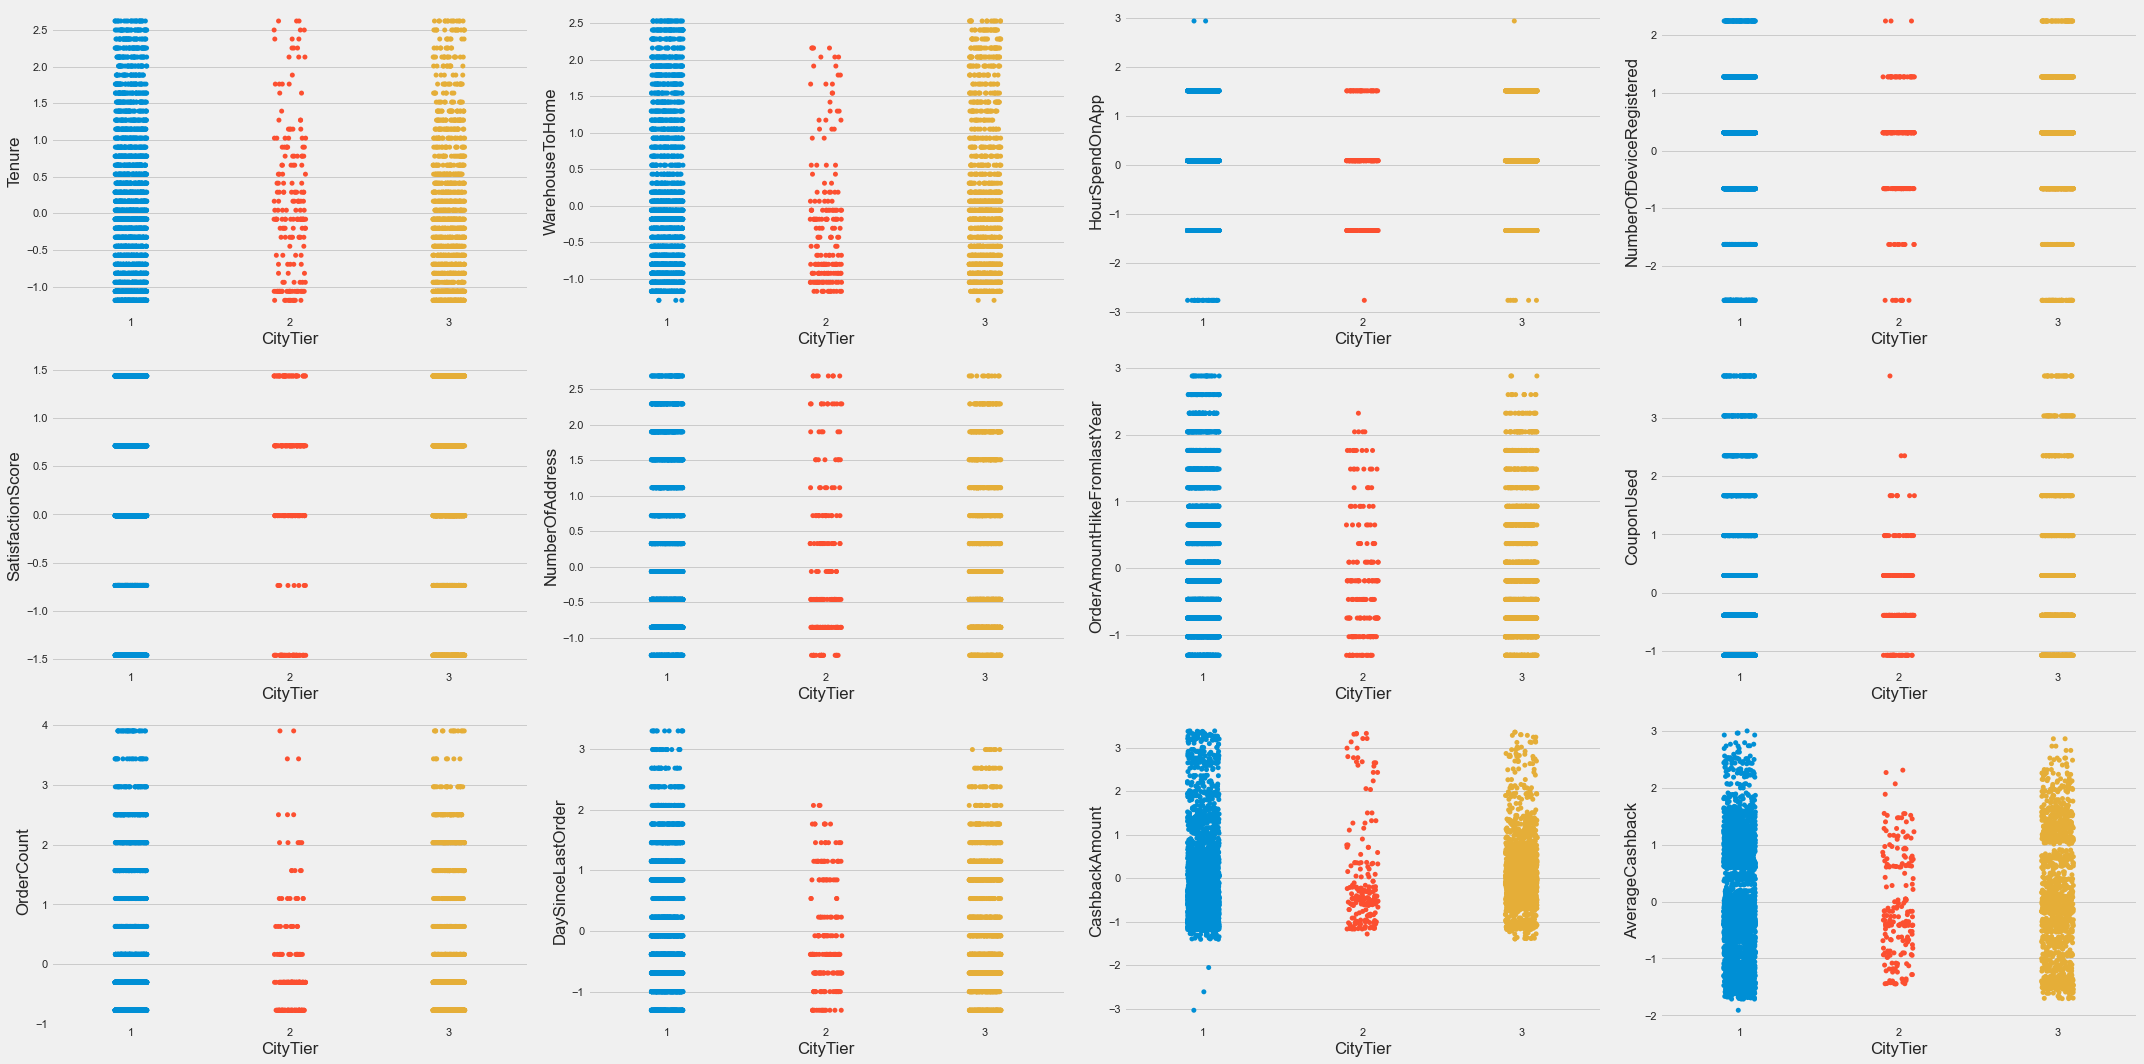

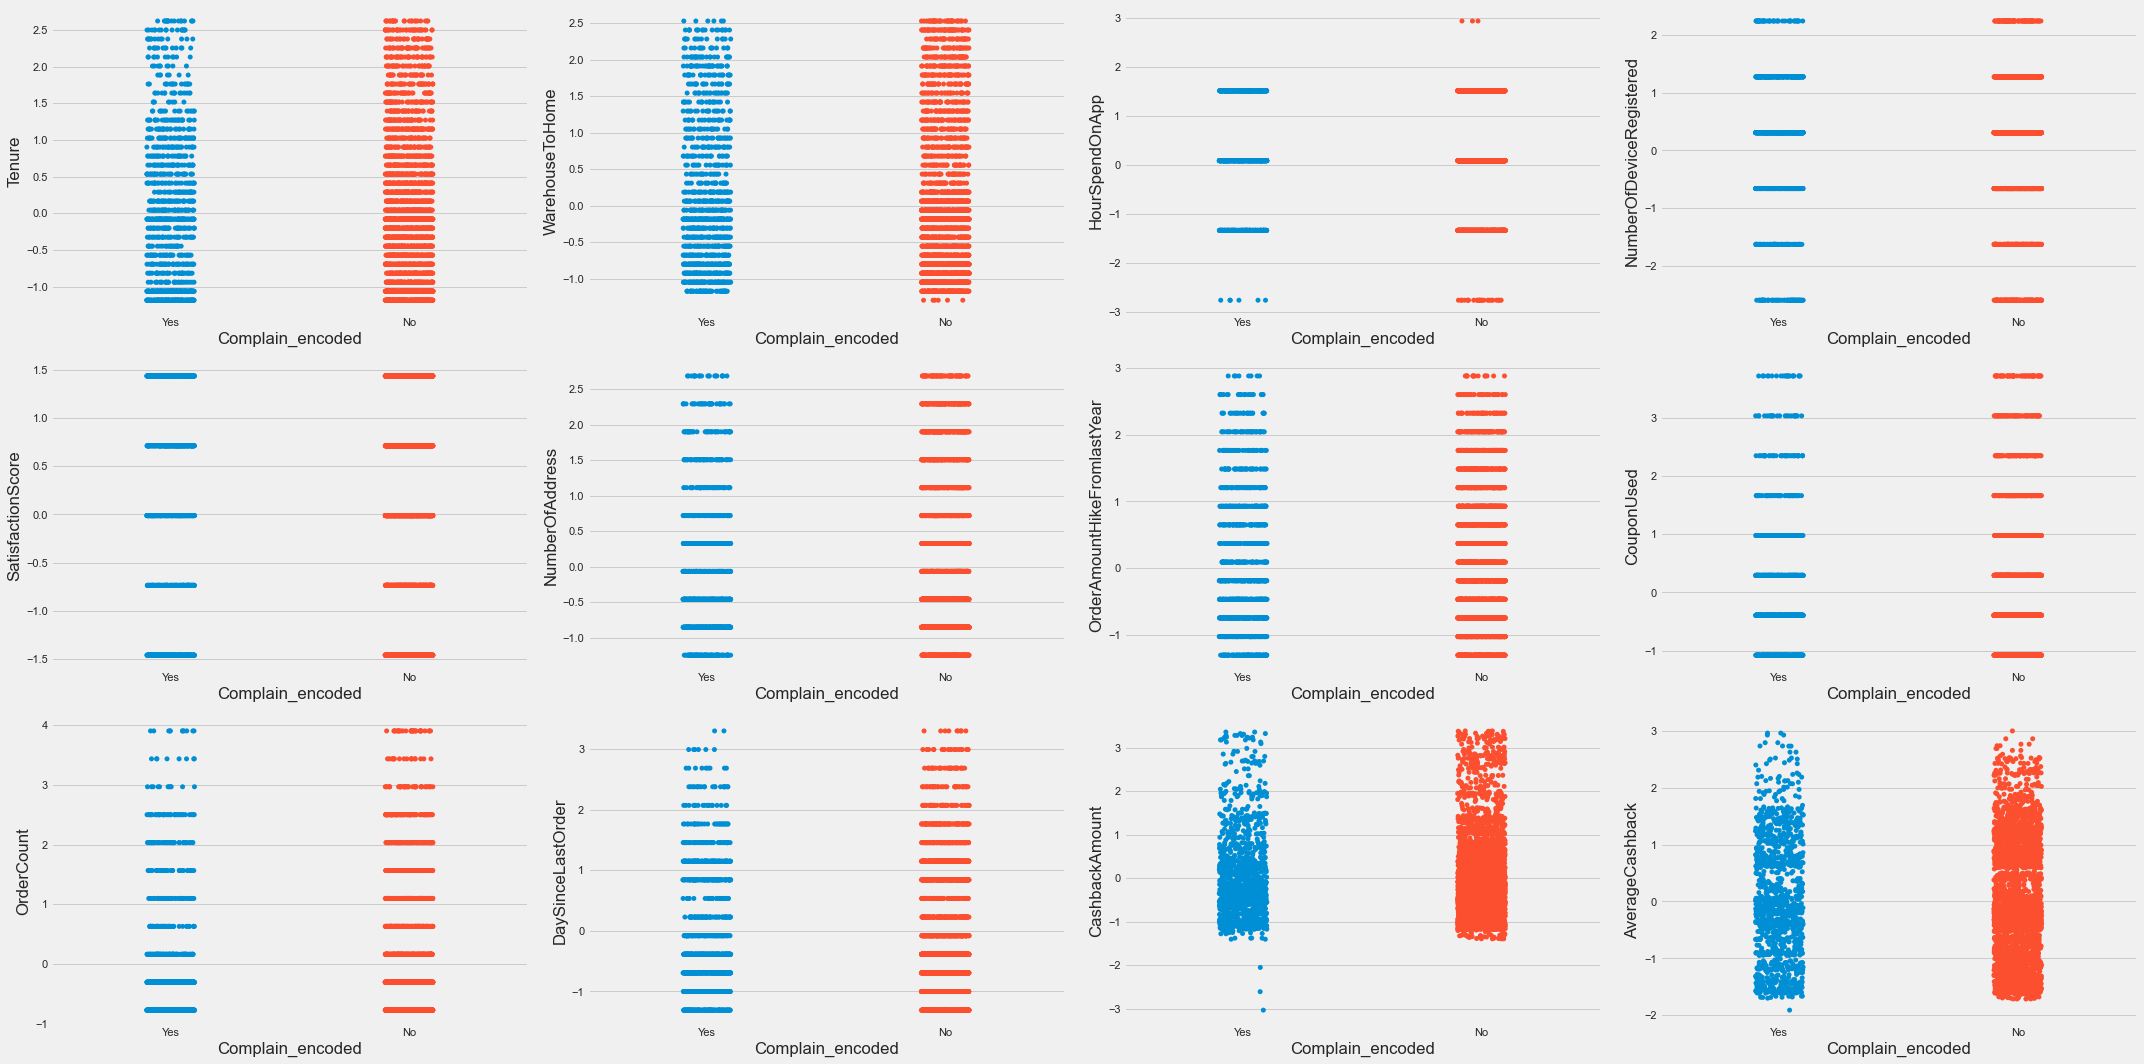

In [56]:
for j in range(0, len(features_cat)):
    fig = plt.figure(figsize=(30, 15))
    for i in range(0, len(features_num)): # untuk setiap kolom numerik
        ax = fig.add_subplot(3, 4, i+1) # kita set posisi catplot/stripplotnya di layout
        sns.stripplot(ax=ax, data=df, x=df[features_cat[j]], y=features_num[i]) # gambar catplot/stripplotnya
        plt.tight_layout() # layout

    #if i != 0: plt.close(i+1) # close figure 

    #plt.close(len(nums) + 1) # close figure 

* `PreferredLoginDevice` terlihat memiliki korelasi dengan `CashbackAmount` dan `AverageCashback`, kategori _phone_ cenderung mendapatkan nilai cashback yang lebih rendah dibandingkan kategori lain. Namun, bisa jadi hal ini diakibatkan data kategori _phone_ yang lebih sedikit daripada data kategori lain (datanya kurang untuk kategori _phone_).
* `PreferredPaymentMode` terlihat memiliki korelasi dengan `CashbackAmount` dan `AverageCashback`, kategori _CC_ dan _COD_ cenderung memiliki nilai cashback yang lebih rendah dibandingkan kategori lain. Hal ini bisa juga disebabkan karena jumlah data yang terlalu sedikit.
* `Gender` terlihat tidak memiliki korelasi dengan feature numerical.
* `PreferedOrderCat` terlihat memiliki korelasi (terutama kategori _Others_) dengan:
> `Tenure`: Kategori _Others_ kebanyakan dibeli oleh customer dengan `Tenure` tinggi <br>
> `WarehouseToHome`: Kategori _Others_ kebanyakan dibeli oleh customer dengan `WarehouseToHome` rendah (customer yang tinggal di tempat yang jauh dengan warehouse cenderung tidak membeli kategori _Others_) <br>
> `OrderAmountHikeFromLastYear`: Kategori _Others_ kebanyakan dibeli oleh customer dengan `OrderAmountHikeFromLastYear` yang rendah <br>
> `CashbackAmount`: Kategori _Others_ cenderung memiliki nilai cashback yang lebih tinggi dibandingkan kategori lain <br>
> `AverageCashback`: Kategori _Fashion_ cenderung memiliki nilai rata-rata cashback yang lebih tinggi dibandingkan kategori lain <br> <br>
> Perlu diingat bahwa hal ini terjadi bisa jadi akibat kurangnya data kategori _Others_.
* `MaritalStatus` terlihat tidak memiliki korelasi dengan feature numerical.
* `CityTier` terlihat tidak memiliki korelasi dengan feature numerical, selain itu data kategori _2_ terlalu sedikit.
* `Complain_encoded` terlihat tidak memiliki korelasi dengan feature numerical.

# <font color='orangered'>Stage 3</font>

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import shap

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,10),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [58]:
df.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'Complain_encoded', 'AverageCashback'],
      dtype='object')

In [59]:
X = df_clean.drop(columns=['churn_SMOTE'])
y = df_clean['churn_SMOTE'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [60]:
# y_train.value_counts()

#### <font color='yellow'>Logistic Regression</font>

In [61]:
from sklearn.linear_model import LogisticRegression
logres = LogisticRegression(random_state=42)
logres.fit(X_train, y_train)

y_pred = logres.predict(X_test)
eval_classification(logres, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.88
Recall (Test Set): 0.87
F1-Score (Test Set): 0.87
AUC: 0.88


In [62]:
print('Train score: ', logres.score(X_train, y_train)) #accuracy
print('Test score:', logres.score(X_test, y_test)) #accuracy

Train score:  0.8807356154406409
Test score: 0.8768054375531011


#### <font color='yellow'>Logistic Regression - TUNED - Random</font>

In [63]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet', None]
C = np.linspace(0.5, 1, 110, endpoint=True)#[0.00001, 0.00002, 0.00003, 0.0001, 0.0002, 0.0003, 0.001, 0.002, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.4, 0.5] # Inverse of regularization strength; smaller values specify stronger regularization.
fit_intercept = [True, False]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
hyperparameters = dict(penalty=penalty, C=C, fit_intercept=fit_intercept, solver=solver)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
logres_tuned_random = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='precision')

# Fitting Model & Evaluation
logres_tuned_random.fit(X_train, y_train)
y_pred = logres_tuned_random.predict(X_test)
eval_classification(logres_tuned_random, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.88
Recall (Test Set): 0.87
F1-Score (Test Set): 0.87
AUC: 0.88


In [64]:
print('Train score: ', logres_tuned_random.score(X_train, y_train)) #precision
print('Test score:', logres_tuned_random.score(X_test, y_test)) #precision

Train score:  0.8944215649569449
Test score: 0.8811188811188811


In [65]:
pd_logres_tuned_random = pd.DataFrame(logres_tuned_random.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
pd_logres_tuned_random

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
9           0.902913           0.887454           0.875686           0.885662   
4           0.903101           0.887454           0.873857           0.886076   
0           0.863894           0.851301           0.838182           0.847943   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
6                NaN                NaN                NaN                NaN   
7                NaN                NaN                NaN                NaN   
8                NaN                NaN                NaN                NaN   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
9           0.906796         0.891702        0.011529                1  
4           0.903475         0.890793        0.011247                2  
0           0.849711         0.850206        0.008228                3  
1                NaN              NaN             NaN                4  
2                NaN              NaN             NaN                5  
3                NaN              NaN             NaN                6  
5                NaN              NaN             NaN                7  
6                NaN              NaN             NaN                8  
7                NaN              NaN             NaN                9  
8                NaN              NaN             NaN               10

In [66]:
print('Best penalty:', logres_tuned_random.best_estimator_.get_params()['penalty'])
print('Best C:', logres_tuned_random.best_estimator_.get_params()['C'])
print('Best fit intercept:', logres_tuned_random.best_estimator_.get_params()['fit_intercept'])
print('Best solver:', logres_tuned_random.best_estimator_.get_params()['solver'])

Best penalty: l1
Best C: 0.5871559633027523
Best fit intercept: True
Best solver: saga


<!-- #### <font color='yellow'>Logistic Regression - TUNED - Grid</font> -->

In [67]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# # List Hyperparameters yang akan diuji
# penalty = ['l2','l1','elasticnet']
# C = [0.00001, 0.00002, 0.00003, 0.0001, 0.0002, 0.0003, 0.001, 0.002, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.4, 0.5] # Inverse of regularization strength; smaller values specify stronger regularization.
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# hyperparameters = dict(penalty=penalty, C=C, solver=solver)

# # Inisiasi model
# logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
# logres_tuned_grid = GridSearchCV(logres, hyperparameters, cv=5, scoring='recall')

# # Fitting Model & Evaluation
# logres_tuned_grid.fit(X_train, y_train)
# y_pred = logres_tuned_grid.predict(X_test)
# eval_classification(logres_tuned_grid, y_pred, X_train, y_train, X_test, y_test)

In [68]:
# print('Train score: ' + str(logres_tuned_grid.score(X_train, y_train))) #recall
# print('Test score:' + str(logres_tuned_grid.score(X_test, y_test))) #recall

In [69]:
# pd_logres_tuned_grid = pd.DataFrame(logres_tuned_grid.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
# pd_logres_tuned_grid

In [70]:
# print('Best penalty:', logres_tuned_grid.best_estimator_.get_params()['penalty'])
# print('Best C:', logres_tuned_grid.best_estimator_.get_params()['C'])
# print('Best fit intercept:', logres_tuned_grid.best_estimator_.get_params()['fit_intercept'])
# print('Best solver:', logres_tuned_grid.best_estimator_.get_params()['solver'])

#### <font color='yellow'>K-nearest Neighbor</font>

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)
eval_classification(knn, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.93
Precision (Test Set): 0.88
Recall (Test Set): 1.00
F1-Score (Test Set): 0.94
AUC: 0.93


In [72]:
print('Train score: ', logres_tuned_random.score(X_train, y_train)) #accuracy
print('Test score:', logres_tuned_random.score(X_test, y_test)) #accuracy

Train score:  0.8944215649569449
Test score: 0.8811188811188811


#### <font color='yellow'>K-nearest Neighbor - TUNED - Random</font>

In [73]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

# List of hyperparameter
n_neighbors = list(range(1,50))
weights = ['uniform','distance']
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
n_jobs = [-1]
hyperparameters = dict(n_neighbors=n_neighbors, weights=weights, p=p, algorithm=algorithm, n_jobs=n_jobs)

# Init model
knn = KNeighborsClassifier()
knn_tuned_random = RandomizedSearchCV(knn, hyperparameters, cv=5, random_state=42, scoring='precision')

# Fit Model & Evaluasi
knn_tuned_random.fit(X_train, y_train)
y_pred = knn_tuned_random.predict(X_test)
eval_classification(knn_tuned_random, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.98
Precision (Test Set): 0.96
Recall (Test Set): 1.00
F1-Score (Test Set): 0.98
AUC: 0.98


In [74]:
print('Train score: ', knn_tuned_random.score(X_train, y_train)) #precision
print('Test score:', knn_tuned_random.score(X_test, y_test)) #precision

Train score:  1.0
Test score: 0.9556650246305419


In [75]:
pd_knn_tuned_random = pd.DataFrame(knn_tuned_random.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
pd_knn_tuned_random

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
8           0.949914           0.944732           0.940273           0.937075   
1           0.930626           0.949827           0.936968           0.933898   
2           0.935484           0.936644           0.929054           0.918469   
5           0.919866           0.923986           0.894309           0.912397   
9           0.916805           0.904290           0.895765           0.898858   
6           0.903279           0.905629           0.892683           0.888889   
3           0.893031           0.895254           0.878400           0.882448   
0           0.896104           0.881029           0.877389           0.881789   
7           0.846512           0.859177           0.821918           0.821589   
4           0.796662           0.785150           0.762634           0.776097   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.953287         0.945056        0.005967                1  
1           0.937075         0.937679        0.006519                2  
2           0.935264         0.930983        0.006796                3  
5           0.928934         0.915899        0.012079                4  
9           0.918060         0.906756        0.009144                5  
6           0.911814         0.900459        0.008461                6  
3           0.906667         0.891160        0.009994                7  
0           0.885113         0.884285        0.006399                8  
7           0.837963         0.837432        0.014472                9  
4           0.779343         0.779977        0.011148               10

In [76]:
print('Best n_neighbors:', knn_tuned_random.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', knn_tuned_random.best_estimator_.get_params()['weights'])
print('Best p:', knn_tuned_random.best_estimator_.get_params()['p'])
print('Best algorithm:', knn_tuned_random.best_estimator_.get_params()['algorithm'])
print('Best n_jobs:', knn_tuned_random.best_estimator_.get_params()['n_jobs'])

Best n_neighbors: 2
Best weights: distance
Best p: 1
Best algorithm: brute
Best n_jobs: -1


In [77]:
# from mlxtend.evaluate import bias_variance_decomp

# avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#         knn_tuned_random, X_train.values, y_train.values, X_test.values, y_test.values, 
#         loss='0-1_loss',
#         random_seed=123)

# print('Average expected loss: %.3f' % avg_expected_loss)
# print('Average bias: %.3f' % avg_bias)
# print('Average variance: %.3f' % avg_var)

<!-- #### <font color='yellow'>K-nearest Neighbor - TUNED - Grid</font> -->

In [78]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from scipy.stats import uniform

# # List of hyperparameter
# n_neighbors = list(range(1,50))
# weights = ['uniform','distance']
# p=[1,2]
# algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
# n_jobs = [-1]
# hyperparameters = dict(n_neighbors=n_neighbors, weights=weights, p=p, algorithm=algorithm, n_jobs=n_jobs)

# # Init model
# knn = KNeighborsClassifier()
# knn_tuned_grid = GridSearchCV(knn, hyperparameters, cv=5, scoring='precision')

# # Fit Model & Evaluasi
# knn_tuned_grid.fit(X_train, y_train)
# y_pred = knn_tuned_grid.predict(X_test)
# eval_classification(knn_tuned_grid, y_pred, X_train, y_train, X_test, y_test)

In [79]:
# print("train Accuracy : ",knn_tuned_grid.score(X_train,y_train))
# print("test Accuracy : ",knn_tuned_grid.score(X_test,y_test))

In [80]:
# print('Best n_neighbors:', knn_tuned_random.best_estimator_.get_params()['n_neighbors'])
# print('Best weights:', knn_tuned_random.best_estimator_.get_params()['weights'])
# print('Best p:', knn_tuned_random.best_estimator_.get_params()['p'])
# print('Best algorithm:', knn_tuned_random.best_estimator_.get_params()['algorithm'])
# print('Best n_jobs:', knn_tuned_random.best_estimator_.get_params()['n_jobs'])

#### <font color='yellow'>Decision Tree</font>

In [81]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
eval_classification(dt, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.94
Precision (Test Set): 0.93
Recall (Test Set): 0.94
F1-Score (Test Set): 0.94
AUC: 0.94


In [82]:
print('Train score: ', dt.score(X_train, y_train)) #accuracy
print('Test score:', dt.score(X_test, y_test)) #accuracy

Train score:  1.0
Test score: 0.935429056924384


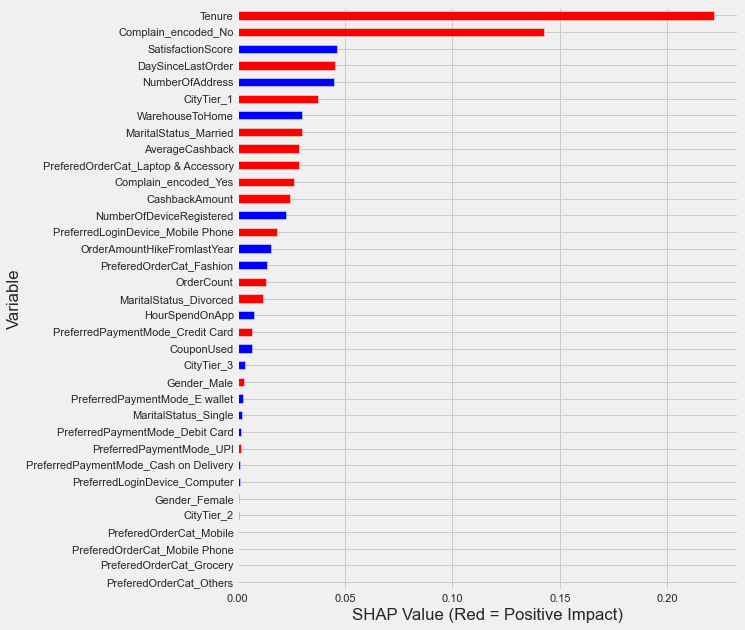

In [83]:
dt_shap_values = shap.TreeExplainer(dt).shap_values(X_train)
ABS_SHAP(dt_shap_values[0],X_train)

#### <font color='yellow'>Decision Tree - TUNED - Random</font>

In [84]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
criterion = ['gini', 'entropy']
# splitter = ['best', 'random']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# min_weight_fraction_leaf = np.linspace(0.0, 0.5, 20, endpoint=True)
max_features = ['auto', 'sqrt', 'log2', None]
# random_state = 42
# max_leaf_nodes = None
# min_impurity_decrease = np.linspace(0.0, 0.5, 20, endpoint=True)
# class_weight = None
# ccp_alpha = np.linspace(0.0, 0.5, 20, endpoint=True)

hyperparameters = dict(
                       criterion=criterion, 
#                        splitter=splitter, 
                       max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf, 
#                        min_weight_fraction_leaf=min_weight_fraction_leaf, 
                       max_features=max_features,
#                        random_state=random_state, 
#                        max_leaf_nodes=max_leaf_nodes, 
#                        min_impurity_decrease=min_impurity_decrease
#                        class_weight=class_weight, 
#                        ccp_alpha=ccp_alpha,
                      )

# Inisiasi model
dt = DecisionTreeClassifier(random_state=42)
dt_tuned_random = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='precision')

# Fitting Model & Evaluation
dt_tuned_random.fit(X_train, y_train)
y_pred = dt_tuned_random.predict(X_test)
eval_classification(dt_tuned_random, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.94
Precision (Test Set): 0.95
Recall (Test Set): 0.94
F1-Score (Test Set): 0.94
AUC: 0.94


In [85]:
print('Train score: ', dt_tuned_random.score(X_train, y_train)) #precision
print('Test score:', dt_tuned_random.score(X_test, y_test)) #precision

Train score:  0.9981610886355278
Test score: 0.9462272333044233


In [86]:
pd_dt_tuned_random = pd.DataFrame(dt_tuned_random.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
pd_dt_tuned_random

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
2           0.911504           0.912886           0.903636           0.936479   
7           0.906137           0.893885           0.886760           0.912568   
6           0.889493           0.903461           0.875000           0.899471   
8           0.871456           0.843206           0.852399           0.879925   
3           0.877778           0.827826           0.828014           0.867647   
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   
5                NaN                NaN                NaN                NaN   
9                NaN                NaN                NaN                NaN   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
2           0.951402         0.923181        0.017875                1  
7           0.907273         0.901325        0.009513                2  
6           0.905967         0.894678        0.011328                3  
8           0.853832         0.860163        0.013461                4  
3           0.857407         0.851735        0.020484                5  
0                NaN              NaN             NaN                6  
1                NaN              NaN             NaN                7  
4                NaN              NaN             NaN                8  
5                NaN              NaN             NaN                9  
9                NaN              NaN             NaN               10

In [87]:
show_best_hyperparameter(dt_tuned_random.best_estimator_, hyperparameters)

Best criterion: entropy
Best max_depth: 91
Best min_samples_split: 4
Best min_samples_leaf: 2
Best max_features: None


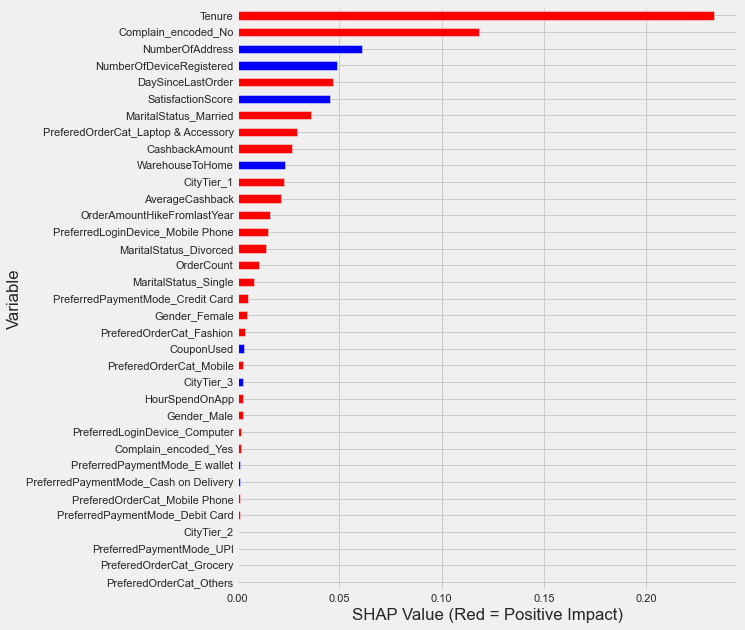

In [88]:
dt_tuned_random_shap_values = shap.TreeExplainer(dt_tuned_random.best_estimator_).shap_values(X_train)
ABS_SHAP(dt_tuned_random_shap_values[0],X_train)

<!-- #### <font color='yellow'>Decision Tree - TUNED - Grid</font> -->

In [89]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# # List Hyperparameters yang akan diuji
# criterion = ['gini', 'entropy']
# # splitter = ['best', 'random']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 30)]
# min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# # min_weight_fraction_leaf = np.linspace(0.0, 0.5, 20, endpoint=True)
# max_features = ['auto', 'sqrt', 'log2', None]
# # random_state = 42
# # max_leaf_nodes = None
# # min_impurity_decrease = np.linspace(0.0, 0.5, 20, endpoint=True)
# # class_weight = None
# # ccp_alpha = np.linspace(0.0, 0.5, 20, endpoint=True)

# hyperparameters = dict(criterion=criterion, 
# #                        splitter=splitter, 
#                        max_depth=max_depth, 
#                        min_samples_split=min_samples_split, 
#                        min_samples_leaf=min_samples_leaf, 
# #                        min_weight_fraction_leaf=min_weight_fraction_leaf, 
#                        max_features=max_features, 
# #                        random_state=random_state, 
# #                        max_leaf_nodes=max_leaf_nodes, 
# #                        min_impurity_decrease=min_impurity_decrease, 
# #                        class_weight=class_weight, 
# #                        ccp_alpha=ccp_alpha
#                       )

# # Inisiasi model
# dt = DecisionTreeClassifier(random_state=42)
# dt_tuned_grid = GridSearchCV(dt, hyperparameters, cv=5, scoring='precision')

# # Fitting Model & Evaluation
# dt_tuned_grid.fit(X_train, y_train)
# y_pred = dt_tuned_grid.predict(X_test)
# eval_classification(dt_tuned_grid, y_pred, X_train, y_train, X_test, y_test)

In [90]:
# print("train Accuracy : ",dt_tuned_grid.score(X_train,y_train))
# print("test Accuracy : ",dt_tuned_grid.score(X_test,y_test))

In [91]:
# show_best_hyperparameter(dt_tuned_grid.best_estimator_, hyperparameters)

In [92]:
# dt_tuned_grid_shap_values = shap.TreeExplainer(dt_tuned_grid.best_estimator_).shap_values(X_train)
# ABS_SHAP(dt_tuned_grid_shap_values[0],X_train)

#### <font color='yellow'>Bagging: Random Forest</font>

In [93]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
eval_classification(rf, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.97
Precision (Test Set): 0.97
Recall (Test Set): 0.97
F1-Score (Test Set): 0.97
AUC: 0.97


In [94]:
print('Train score: ', dt_tuned_random.score(X_train, y_train)) #accuracy
print('Test score:', dt_tuned_random.score(X_test, y_test)) #accuracy

Train score:  0.9981610886355278
Test score: 0.9462272333044233


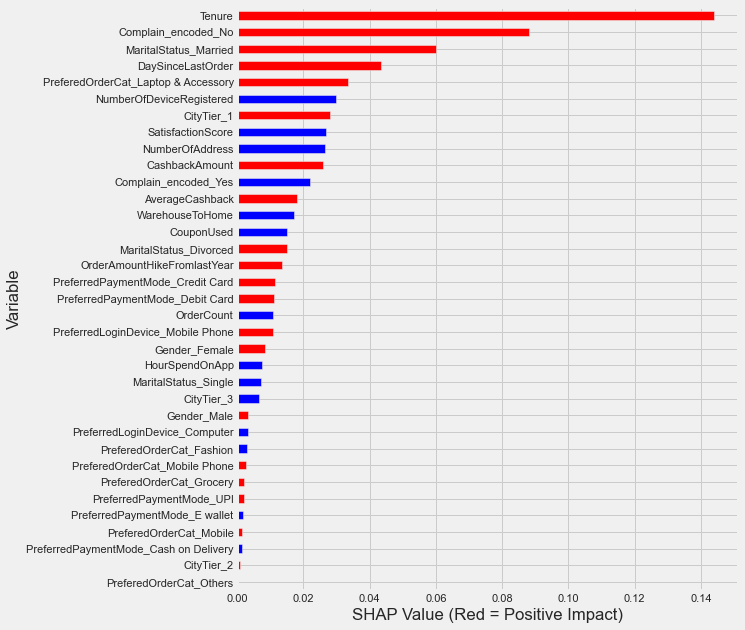

In [95]:
rf_shap_values = shap.TreeExplainer(rf).shap_values(X_train)
ABS_SHAP(rf_shap_values[0],X_train)

#### <font color='yellow'>Bagging: Random Forest - TUNED - Random</font>

In [96]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned_random = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='precision')
rf_tuned_random.fit(X_train,y_train)

# Predict & Evaluation
y_pred = rf_tuned_random.predict(X_test)#Check performa dari model
eval_classification(rf_tuned_random, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.97
Precision (Test Set): 0.98
Recall (Test Set): 0.97
F1-Score (Test Set): 0.97
AUC: 0.97


In [97]:
print('Train score: ', rf_tuned_random.score(X_train, y_train)) #precision
print('Test score:', rf_tuned_random.score(X_test, y_test)) #precision

Train score:  1.0
Test score: 0.9750644883920895


In [98]:
pd_rf_tuned_random = pd.DataFrame(rf_tuned_random.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
pd_rf_tuned_random

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
6           0.976234           0.972826           0.940141           0.959436   
7           0.963303           0.951526           0.919156           0.945035   
0           0.956124           0.951087           0.909894           0.938380   
3           0.959707           0.951087           0.905429           0.935201   
2           0.957798           0.951087           0.903846           0.933566   
8           0.953358           0.941818           0.901235           0.927305   
4           0.947858           0.936248           0.900885           0.923488   
1           0.945591           0.932849           0.902309           0.921986   
9           0.950943           0.928962           0.896309           0.915789   
5           0.944238           0.927798           0.901408           0.921847   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
6           0.983333         0.966394        0.015250                1  
7           0.970370         0.949878        0.017721                2  
0           0.964684         0.944034        0.019078                3  
3           0.959259         0.942137        0.020384                4  
2           0.959259         0.941111        0.020751                5  
8           0.955224         0.935788        0.019944                6  
4           0.947170         0.931130        0.017530                7  
1           0.945794         0.929706        0.016317                8  
9           0.940631         0.926527        0.019128                9  
5           0.935185         0.926095        0.014437               10

In [99]:
show_best_hyperparameter(rf_tuned_random.best_estimator_, hyperparameters)

Best n_estimators: 400
Best bootstrap: True
Best criterion: gini
Best max_depth: 110
Best min_samples_split: 4
Best min_samples_leaf: 1
Best max_features: log2
Best n_jobs: -1


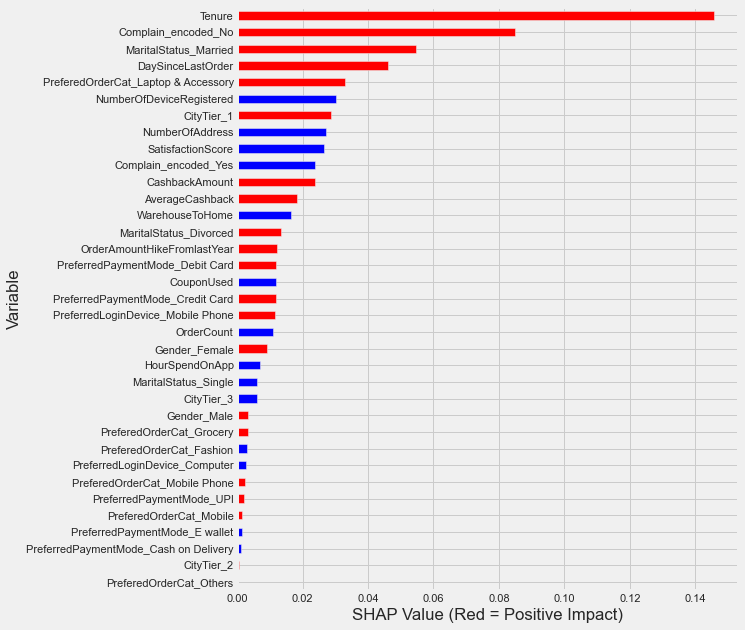

In [100]:
rf_tuned_random_shap_values = shap.TreeExplainer(rf_tuned_random.best_estimator_).shap_values(X_train)
ABS_SHAP(rf_tuned_random_shap_values[0],X_train)

<!-- #### <font color='yellow'>Bagging: Random Forest - TUNED - Grid</font> -->

In [101]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# #List Hyperparameters yang akan diuji
# hyperparameters = dict(
#                        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
#                        bootstrap = [True], # Apakah pakai bootstrapping atau tidak
#                        criterion = ['gini','entropy'],
#                        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
#                        min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
#                        min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
#                        max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
#                        n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
#                       )

# # Init
# rf = RandomForestClassifier(random_state=42)
# rf_tuned_grid = GridSearchCV(rf, hyperparameters, cv=5, scoring='precision')
# rf_tuned_grid.fit(X_train,y_train)

# # Predict & Evaluation
# y_pred = rf_tuned_grid.predict(X_test)#Check performa dari model
# eval_classification(rf_tuned_grid, y_pred, X_train, y_train, X_test, y_test)

In [102]:
# print("train Accuracy : ",rf_tuned_grid.score(X_train,y_train))
# print("test Accuracy : ",rf_tuned_grid.score(X_test,y_test))

In [103]:
# show_best_hyperparameter(rf_tuned_grid.best_estimator_, hyperparameters)

In [104]:
# show_feature_importance(rf_tuned_grid.best_estimator_)

#### <font color='yellow'>Boosting: AdaBoost</font>

In [105]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)

y_pred = ab.predict(X_test)
eval_classification(ab, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.90
Precision (Test Set): 0.90
Recall (Test Set): 0.91
F1-Score (Test Set): 0.90
AUC: 0.90


In [106]:
print('Train score: ', ab.score(X_train, y_train)) #accuracy
print('Test score:', ab.score(X_test, y_test)) #accuracy

Train score:  0.9104151493080845
Test score: 0.9022939677145284


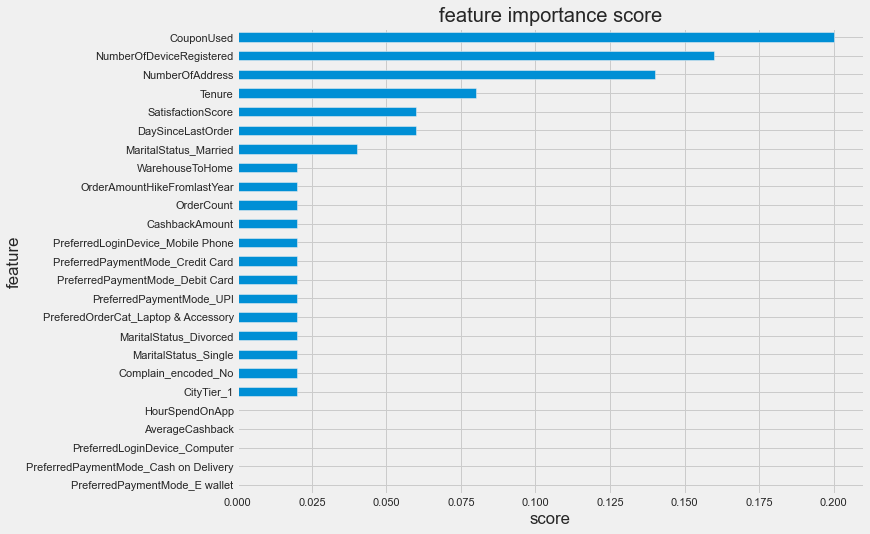

In [107]:
show_feature_importance(ab)

#### <font color='yellow'>Boosting: AdaBoost - TUNED - Random</font>

In [108]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned_random = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='precision')
ab_tuned_random.fit(X_train,y_train)

# Predict & Evaluation
y_pred = ab_tuned_random.predict(X_test)#Check performa dari model
eval_classification(ab_tuned_random, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.92
Recall (Test Set): 0.91
F1-Score (Test Set): 0.92
AUC: 0.92


In [109]:
print('Train score: ', ab_tuned_random.score(X_train, y_train)) #precision
print('Test score:', ab_tuned_random.score(X_test, y_test)) #precision

Train score:  0.9252539912917271
Test score: 0.917312661498708


In [110]:
pd_ab_tuned_random = pd.DataFrame(ab_tuned_random.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
pd_ab_tuned_random

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.942966           0.925859           0.884615           0.920290   
1           0.920605           0.911232           0.874113           0.906028   
3           0.913696           0.904332           0.872340           0.895204   
7           0.902913           0.889299           0.850799           0.868881   
9           0.900778           0.885553           0.847247           0.858392   
6           0.873077           0.871940           0.823427           0.852686   
5           0.874517           0.870787           0.823117           0.851916   
8           0.873786           0.864662           0.821239           0.843750   
4           0.828947           0.828571           0.790235           0.820557   
2           0.830827           0.828125           0.790826           0.818499   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.935065         0.921759        0.020127                1  
1           0.910420         0.904480        0.015909                2  
3           0.907749         0.898664        0.014460                3  
7           0.897436         0.881866        0.019362                4  
9           0.887868         0.875968        0.019914                5  
6           0.869963         0.858219        0.018911                6  
5           0.867890         0.857646        0.018907                7  
8           0.861878         0.853063        0.018661                8  
4           0.813743         0.816411        0.014244                9  
2           0.812274         0.816110        0.014288               10

In [111]:
show_best_hyperparameter(ab_tuned_random.best_estimator_, hyperparameters)

Best n_estimators: 1700
Best learning_rate: 0.07394736842105264
Best algorithm: SAMME.R


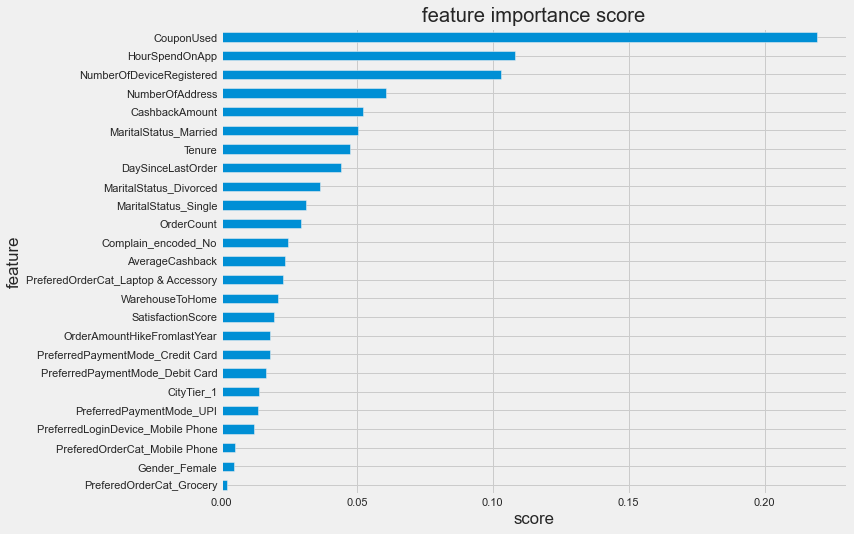

In [112]:
show_feature_importance(ab_tuned_random.best_estimator_)

<!-- #### <font color='yellow'>Boosting: AdaBoost - TUNED - Grid</font> -->

In [113]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import numpy as np

# # List of hyperparameter
# hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
#                        learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
#                        algorithm = ['SAMME', 'SAMME.R']
#                       )

# # Init model
# ab = AdaBoostClassifier(random_state=42)
# ab_tuned_grid = GridSearchCV(ab, hyperparameters, cv=5, scoring='precision')
# ab_tuned_grid.fit(X_train,y_train)

# # Predict & Evaluation
# y_pred = ab_tuned_grid.predict(X_test)#Check performa dari model
# eval_classification(ab_tuned_grid, y_pred, X_train, y_train, X_test, y_test)

In [114]:
# print("train Accuracy : ",ab_tuned_grid.score(X_train,y_train))
# print("test Accuracy : ",ab_tuned_grid.score(X_test,y_test))

In [115]:
# show_best_hyperparameter(ab_tuned_grid.best_estimator_, hyperparameters)

In [116]:
# show_feature_importance(ab_tuned_grid.best_estimator_)

#### <font color='yellow'>Boosting: XGBoost</font>

In [117]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)
eval_classification(xg, y_pred, X_train, y_train, X_test, y_test)

[13:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.98
Precision (Test Set): 0.98
Recall (Test Set): 0.98
F1-Score (Test Set): 0.98
AUC: 0.98


In [118]:
print('Train score: ', xg.score(X_train, y_train)) #accuracy
print('Test score:', xg.score(X_test, y_test)) #accuracy

Train score:  1.0
Test score: 0.9804587935429057


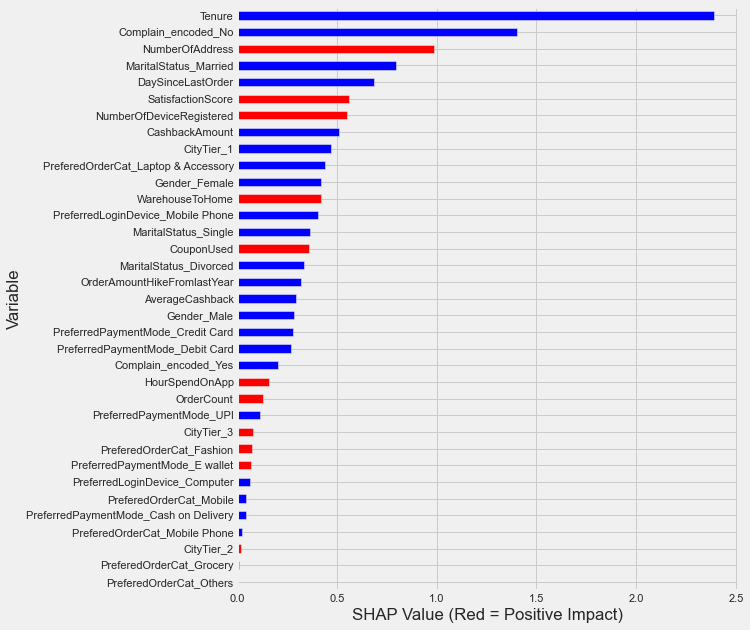

In [119]:
xg_shap_values = shap.TreeExplainer(xg).shap_values(X_test)
ABS_SHAP(xg_shap_values,X_test)

#### <font color='yellow'>Boosting: XGBoost - TUNED - Random</font>

In [120]:

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                   'alpha':[0.1],  'booster':['gbtree'],
                   'colsample_bylevel':[0.5], 'colsample_bynode':[0.5], 'colsample_bytree':[0.5],
                   'enable_categorical':[False], 'eta':[0], 'gamma':[0.1],
                   'gpu_id':[-1], 'importance_type':[None],
                   'lambda':[0], 'learning_rate':[0.1], 'max_delta_step':[1],
                   'max_depth':[91], 'min_child_weight':[1],
                   'monotone_constraints':['()'], 'n_estimators':[250], 'n_jobs':[12],
                   'num_parallel_tree':[1], 'predictor':['auto'], 'random_state':[42],
                   'reg_alpha':[0.2], 'reg_lambda':[0.15], 'scale_pos_weight':[2],
                   'subsample':[1], 'tree_method':['approx'], 'validate_parameters':[1]
                    }

# Init
xg = XGBClassifier(random_state=42, eval_metric='logloss')
xg_tuned_random = RandomizedSearchCV(xg, hyperparameters, cv=15, random_state=42, scoring='precision')
xg_tuned_random.fit(X_train,y_train)


# Predict & Evaluation
y_pred = xg_tuned_random.predict(X_test)#Check performa dari model
eval_classification(xg_tuned_random, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.99
Precision (Test Set): 0.98
Recall (Test Set): 0.99
F1-Score (Test Set): 0.98
AUC: 0.99


In [121]:
print('Train score: ', xg_tuned_random.score(X_train, y_train)) #precision
print('Test score:', xg_tuned_random.score(X_test, y_test)) #precision

Train score:  1.0
Test score: 0.9837189374464439


In [122]:
show_best_hyperparameter(xg_tuned_random.best_estimator_, hyperparameters)

Best alpha: 0.1
Best booster: gbtree
Best colsample_bylevel: 0.5
Best colsample_bynode: 0.5
Best colsample_bytree: 0.5
Best enable_categorical: False
Best eta: 0
Best gamma: 0.1
Best gpu_id: -1
Best importance_type: None
Best lambda: 0
Best learning_rate: 0.1
Best max_delta_step: 1
Best max_depth: 91
Best min_child_weight: 1
Best monotone_constraints: ()
Best n_estimators: 250
Best n_jobs: 12
Best num_parallel_tree: 1
Best predictor: auto
Best random_state: 42
Best reg_alpha: 0.2
Best reg_lambda: 0.15
Best scale_pos_weight: 2
Best subsample: 1
Best tree_method: approx
Best validate_parameters: 1


In [123]:
pd_xg_tuned_random = pd.DataFrame(xg_tuned_random.cv_results_, columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','std_test_score','rank_test_score']).sort_values("rank_test_score")
pd_xg_tuned_random

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.967213           0.983516           0.989071           0.994444   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.983696         0.979089        0.011497                1

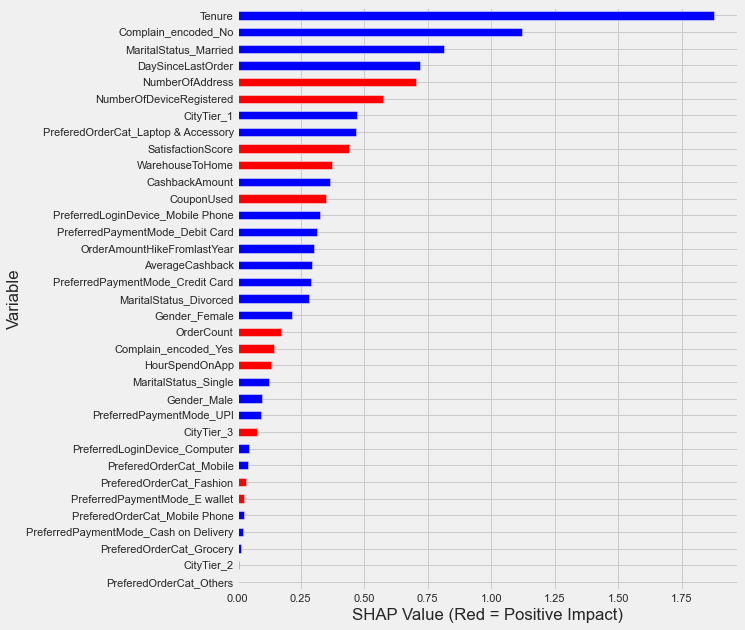

In [124]:
xg_tuned_random_shap_values = shap.TreeExplainer(xg_tuned_random.best_estimator_).shap_values(X_train)
ABS_SHAP(xg_tuned_random_shap_values,X_train)

In [139]:
from mlxtend.evaluate import bias_variance_decomp

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        xg_tuned_random, X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.029
Average bias: 0.017
Average variance: 0.016


In [145]:
error_reg, bias_reg, var_reg = bias_variance_decomp(xg_tuned_random, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', random_seed=123)
error_no_reg, bias_no_reg, var_no_reg = bias_variance_decomp(xg, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', random_seed=123)
print("variance Reduction:", (var_reg/var_no_reg-1)*100)
print("At the expense of introducing bias:", (bias_reg/bias_no_reg-1)*100)

variance Reduction: -26.70158444761087
At the expense of introducing bias: -3.264192563362467


In [126]:

# error_dt, bias_dt, var_xg = bias_variance_decomp(xg, X_train.values, y_train.values, X_test.values, y_test.values,'mse', random_seed=123)

# error_rf, bias_rf, var_xg_tuned_random = bias_variance_decomp(xg_tuned_random, X_train.values, y_train.values, X_test.values, y_test.values,'mse', random_seed=123)

# print("variance Reduction:", str(np.round((var_xg_tuned_random/var_xg-1)*100,2))+ '%')
# print("At the expense of introducing bias:", str(np.round((var_xg_tuned_random/var_xg-1)*100, 2)) + '%')

<!-- #### <font color='yellow'>Boosting: XGBoost - TUNED - Grid</font> -->

In [127]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import numpy as np

# #Menjadikan ke dalam bentuk dictionary
# hyperparameters = {
#                     'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#                     'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
#                     'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'tree_method' : ['auto', 'exact', 'approx', 'hist'],

#                     'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

#                     'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
#                     }

# # Init
# xg = XGBClassifier(random_state=42)
# xg_tuned_grid = GridSearchCV(xg, hyperparameters, cv=5, scoring='precision')
# xg_tuned_grid.fit(X_train,y_train)

# # Predict & Evaluation
# y_pred = xg_tuned_grid.predict(X_test)#Check performa dari model
# eval_classification(xg_tuned_grid, y_pred, X_train, y_train, X_test, y_test)

In [128]:
# print("train Accuracy : ",xg_tuned_grid.score(X_train,y_train))
# print("test Accuracy : ",xg_tuned_grid.score(X_test,y_test))

In [129]:
# show_best_hyperparameter(xg_tuned_grid.best_estimator_, hyperparameters)

In [130]:
# show_feature_importance(xg_tuned_grid.best_estimator_)

#### <font color='yellow'>Stacking</font>

In [131]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, model, hyperparameters, cv=5, scoring_fit='precision', scoring_test=precision_score):
    rs = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, cv=cv, n_jobs=-1, scoring=scoring_fit, verbose=0, random_state=42) # Use GridSearch better if you have more resource & time
    rs.fit(X_train_data, y_train_data)
    best_model = rs.best_estimator_
    
    pred = rs.predict(X_test_data)
    score = scoring_test(y_test_data, pred)
    return [best_model, pred, score]

In [132]:
models_to_train = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier(random_state=42), XGBClassifier(random_state=42)]

# Defining the hyperparameters to optimize
grid_parameters = [
    { # Logistic Regression
        'penalty' : ['l2','l1','elasticnet', None],
        'C' : [0.00001, 0.00002, 0.00003, 0.0001, 0.0002, 0.0003, 0.001, 0.002, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.4, 0.5],
        'fit_intercept' : [True, False]
    },
    { # KNearestNeighbor
        'leaf_size': list(range(1,50)),
        'n_neighbors': list(range(1,50)),
        'weights' : ['uniform','distance'],
        'p': [1,2],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'n_jobs' : [-1]
    }, 
    { # Decision Tree
        'max_depth': np.linspace(1, 110, 110, endpoint=True),
#         'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
#         'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
        'max_features': list(range(1,X_train.shape[1])),
        'criterion' : ['gini', 'entropy']
    }, 
    { # Random Forest
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'criterion': ['gini','entropy'],
        'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)],
        'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
        'bootstrap': [True],
        'n_jobs': [-1]
    },
    { # Adaboost
       'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
       'learning_rate': [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],
       'algorithm': ['SAMME', 'SAMME.R']
    },
    { # XGBoost
        'max_depth' : [int(x) for x in np.linspace(10, 110, num = 30)],
        'min_child_weight' : [int(x) for x in np.linspace(1, 2, num = 2)],
        'gamma' : [float(x) for x in np.linspace(0, 0.5, num = 11)],
        'tree_method' : ['auto', 'exact', 'approx', 'hist'],

        'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
        'eta' : [float(x) for x in np.linspace(0, 0.5, num = 100)],

        'lambda' : [float(x) for x in np.linspace(0, 0.5, num = 11)],
        'alpha' : [float(x) for x in np.linspace(0, 0.5, num = 11)]
    }
]

In [133]:
models_preds_scores = []

for i, model in enumerate(models_to_train):
    hyperparameters = grid_parameters[i]
    result = algorithm_pipeline(X_train, X_test, y_train, y_test,  model, hyperparameters, cv=5)
    models_preds_scores.append(result)

[13:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [134]:
for result in models_preds_scores:
    print('Model: {0}, Score: {1}'.format(type(result[0]).__name__, result[2])) # score in training data

Model: LogisticRegression, Score: 0.8762975778546713
Model: KNeighborsClassifier, Score: 0.90703125
Model: DecisionTreeClassifier, Score: 0.9353484466834593
Model: RandomForestClassifier, Score: 0.9709897610921502
Model: AdaBoostClassifier, Score: 0.917312661498708
Model: XGBClassifier, Score: 0.9836629406706793


In [135]:
models_preds_scores[5]

[XGBClassifier(alpha=0.15000000000000002, base_score=0.5, booster='gbtree',
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
               enable_categorical=False, eta=0.14141414141414144, gamma=0.45,
               gpu_id=-1, importance_type=None, interaction_constraints='',
               lambda=0.25, learning_rate=0.141414136, max_delta_step=0,
               max_depth=37, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=12,
               num_parallel_tree=1, predictor='auto', random_state=42,
               reg_alpha=0.150000006, reg_lambda=0.25, scale_pos_weight=1,
               subsample=1, tree_method='approx', validate_parameters=1, ...),
 array([1, 0, 1, ..., 0, 1, 1], dtype=int64),
 0.9836629406706793]

In [136]:
# define level-1 algorithm
level1 = list()
level1.append(('lr', LogisticRegression(penalty='l1', C=0.5, solver='saga')))
level1.append(('knn', KNeighborsClassifier(leaf_size=48, n_neighbors=2, weights='distance', p=1, algorithm='brute', n_jobs=-1)))
level1.append(('dt', DecisionTreeClassifier(criterion='entropy', max_depth=104.0, max_features=X_train.shape[1])))
level1.append(('rf', RandomForestClassifier(max_depth=110, max_features='sqrt', min_samples_leaf=5, min_samples_split=10, n_estimators=1600, n_jobs=-1)))
level1.append(('ab', AdaBoostClassifier(learning_rate=0.05831578947368421, n_estimators=200, random_state=42)))

# define level-2 algorithm
level2 = XGBClassifier(alpha=0.30000000000000004, base_score=0.5, booster='gbtree',
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7777777777777777,
                eta=0.18181818181818182, gamma=0.1, gpu_id=-1,
                importance_type='gain',
                learning_rate=0.13131313, max_delta_step=0, max_depth=35,
                min_child_weight=5, monotone_constraints='()',
                n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=42,
                reg_alpha=0.1111111111111111, reg_lambda=0, scale_pos_weight=1,
                subsample=1, tree_method='approx', validate_parameters=1,
                verbosity=None, eval_metric='logloss', scoring = 'precision')

# Fit model
stacking_model = StackingClassifier(estimators=level1, final_estimator=level2, cv=5)
stacking_model.fit(X_train,y_train)
y_pred = stacking_model.predict(X_test)#Check performa dari model
eval_classification(stacking_model, y_pred, X_train, y_train, X_test, y_test)

[13:39:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy (Test Set): 0.99
Precision (Test Set): 0.98
Recall (Test Set): 0.99
F1-Score (Test Set): 0.99
AUC: 0.99


In [137]:
print('Train score: ', stacking_model.score(X_train, y_train)) #recall
print('Test score:', stacking_model.score(X_test, y_test)) #recall

Train score:  1.0
Test score: 0.9872557349192863


#### Score

In [138]:
print('logres Train score: ', logres_tuned_random.score(X_train, y_train)) #precision
print('logres Test score:', logres_tuned_random.score(X_test, y_test)) #precision
print('Diff: ', logres_tuned_random.score(X_train, y_train) - logres_tuned_random.score(X_test, y_test),"\n")

print('KNN Train score: ', knn_tuned_random.score(X_train, y_train)) #precision
print('KNN Test score:', knn_tuned_random.score(X_test, y_test)) #precision
print('Diff: ', knn_tuned_random.score(X_train, y_train) - knn_tuned_random.score(X_test, y_test),"\n")

print('Decision Tree Train score: ', dt_tuned_random.score(X_train, y_train)) #precision
print('Decision Tree Test score:', dt_tuned_random.score(X_test, y_test)) #precision
print('Diff: ', dt_tuned_random.score(X_train, y_train) - dt_tuned_random.score(X_test, y_test),"\n")

print('Random Forest Train score: ', rf_tuned_random.score(X_train, y_train)) #precision
print('Random Forest Test score:', rf_tuned_random.score(X_test, y_test)) #precision
print('Diff: ', rf_tuned_random.score(X_train, y_train) - rf_tuned_random.score(X_test, y_test),"\n")

print('AdaBoost Train score: ', ab_tuned_random.score(X_train, y_train)) #precision
print('AdaBoost Test score:', ab_tuned_random.score(X_test, y_test)) #precision
print('Diff: ', ab_tuned_random.score(X_train, y_train) - ab_tuned_random.score(X_test, y_test),"\n")

print('XGBoost Train score: ', xg_tuned_random.score(X_train, y_train)) #precision
print('XGBoost Test score:', xg_tuned_random.score(X_test, y_test)) #precision
print('Diff: ', xg_tuned_random.score(X_train, y_train) - xg_tuned_random.score(X_test, y_test),"\n")

print('Stacking Train score: ', stacking_model.score(X_train, y_train)) #precision
print('Stacking Test score:', stacking_model.score(X_test, y_test)) #precision
print('Diff: ', stacking_model.score(X_train, y_train) - stacking_model.score(X_test, y_test),"\n")

logres Train score:  0.8944215649569449
logres Test score: 0.8811188811188811
Diff:  0.013302683838063767 

KNN Train score:  1.0
KNN Test score: 0.9556650246305419
Diff:  0.044334975369458074 

Decision Tree Train score:  0.9981610886355278
Decision Tree Test score: 0.9462272333044233
Diff:  0.051933855331104506 

Random Forest Train score:  1.0
Random Forest Test score: 0.9750644883920895
Diff:  0.02493551160791052 

AdaBoost Train score:  0.9252539912917271
AdaBoost Test score: 0.917312661498708
Diff:  0.007941329793019092 

XGBoost Train score:  1.0
XGBoost Test score: 0.9837189374464439
Diff:  0.016281062553556103 

Stacking Train score:  1.0
Stacking Test score: 0.9872557349192863
Diff:  0.01274426508071369 

